| Band | Wavelength (µm) | Resolution (m) | Description / Use                                                  |
| ---- | --------------- | -------------- | ------------------------------------------------------------------ |
| 1    | 0.443           | 60             | Coastal aerosol, useful for coastal and aerosol studies            |
| 2    | 0.490           | 10             | Blue, for water bodies, atmospheric correction, bathymetry         |
| 3    | 0.560           | 10             | Green, vegetation monitoring, chlorophyll detection                |
| 4    | 0.665           | 10             | Red, vegetation analysis, chlorophyll content                      |
| 5    | 0.705           | 20             | Vegetation Red Edge 1, plant stress detection                      |
| 6    | 0.740           | 20             | Vegetation Red Edge 2, vegetation health assessment                |
| 7    | 0.783           | 20             | Vegetation Red Edge 3, vegetation monitoring, biomass estimation   |
| 8    | 0.842           | 10             | NIR (Near Infrared), vegetation vigor, biomass, water detection    |
| 8a   | 0.865           | 20             | Narrow NIR, improved vegetation analysis                           |
| 9    | 0.945           | 60             | Water vapor absorption, cloud screening                            |
| 10   | 1.375           | 60             | Cirrus detection, high-altitude cloud monitoring                   |
| 11   | 1.610           | 20             | SWIR 1, moisture content of soil and vegetation, snow detection    |
| 12   | 2.190           | 20             | SWIR 2, moisture content, burned area detection, vegetation stress |


In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import numpy as np
import seaborn as sns
import tensorflow_datasets as tfds
import os
import random


In [2]:
dataset, info = tfds.load("eurosat/all", with_info=True, as_supervised=True)

num_classes = info.features['label'].num_classes
class_names = info.features['label'].names
total_samples = info.splits['train'].num_examples

print(f"Total samples: {total_samples}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Total samples: 27000
Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


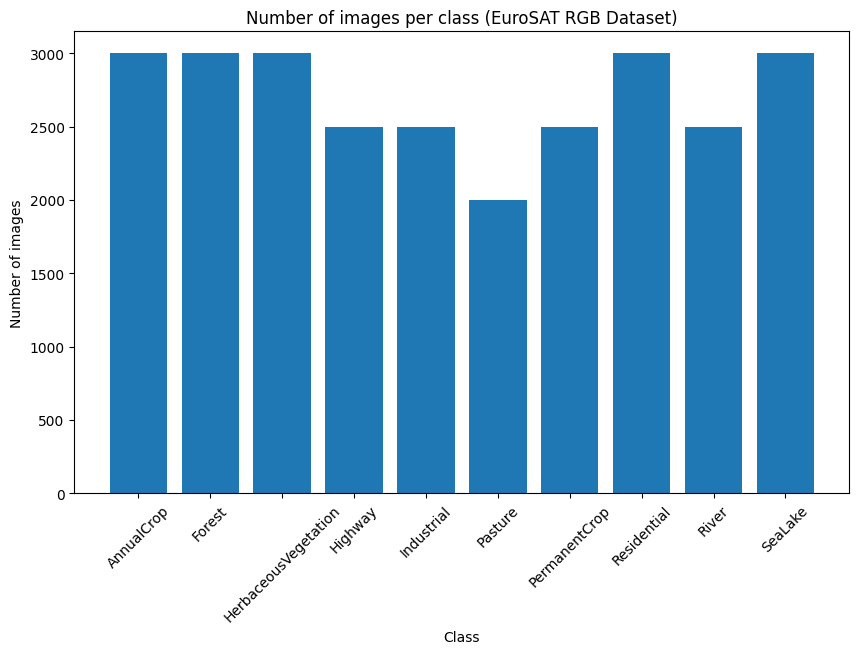

In [4]:
train_ds = dataset['train']

counts = [0] * num_classes

for example in tfds.as_numpy(train_ds):
    label = example[1]
    counts[label] += 1

plt.figure(figsize=(10,6))
plt.bar(class_names, counts)
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.title("Number of images per class (EuroSAT RGB Dataset)")
plt.xticks(rotation=45)
plt.show()

In [5]:
train_ds = dataset['train']

shapes = []

for example in tfds.as_numpy(train_ds):
    img = example[0]
    shapes.append(img.shape)

unique_shapes = set(shapes)
print("\nUnique image shapes in TFDS EuroSAT MSI dataset:", unique_shapes)


Unique image shapes in TFDS EuroSAT MSI dataset: {(64, 64, 13)}


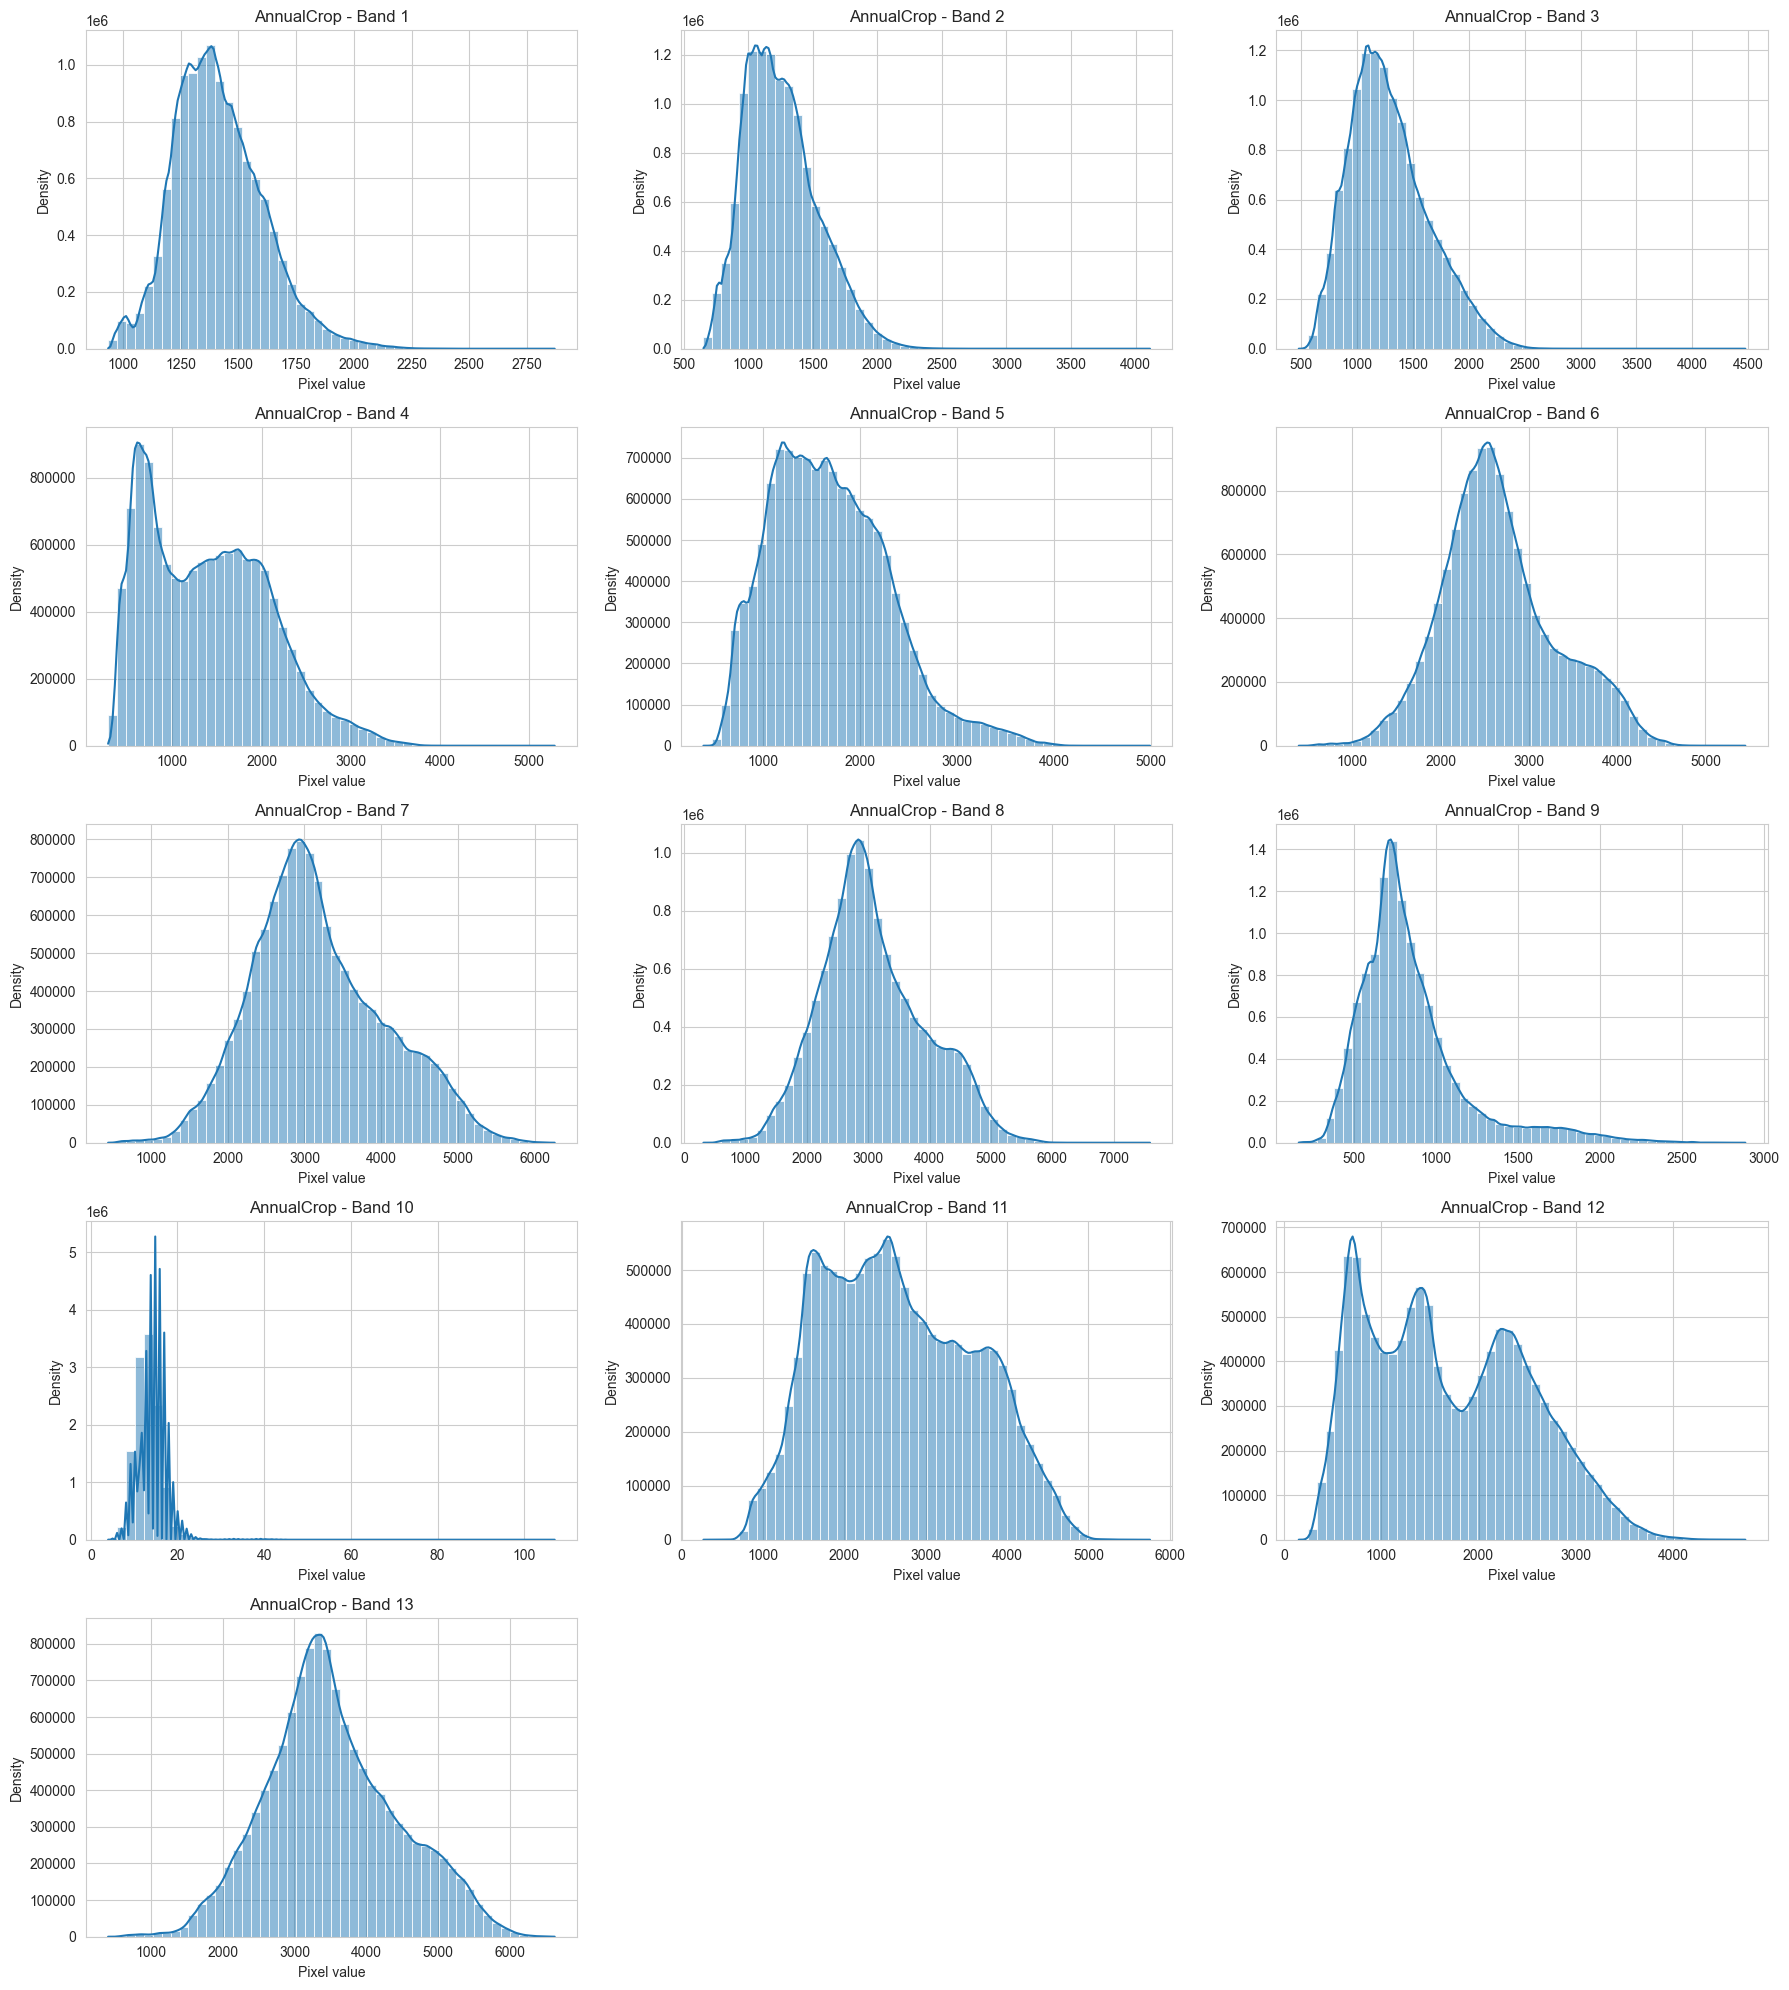

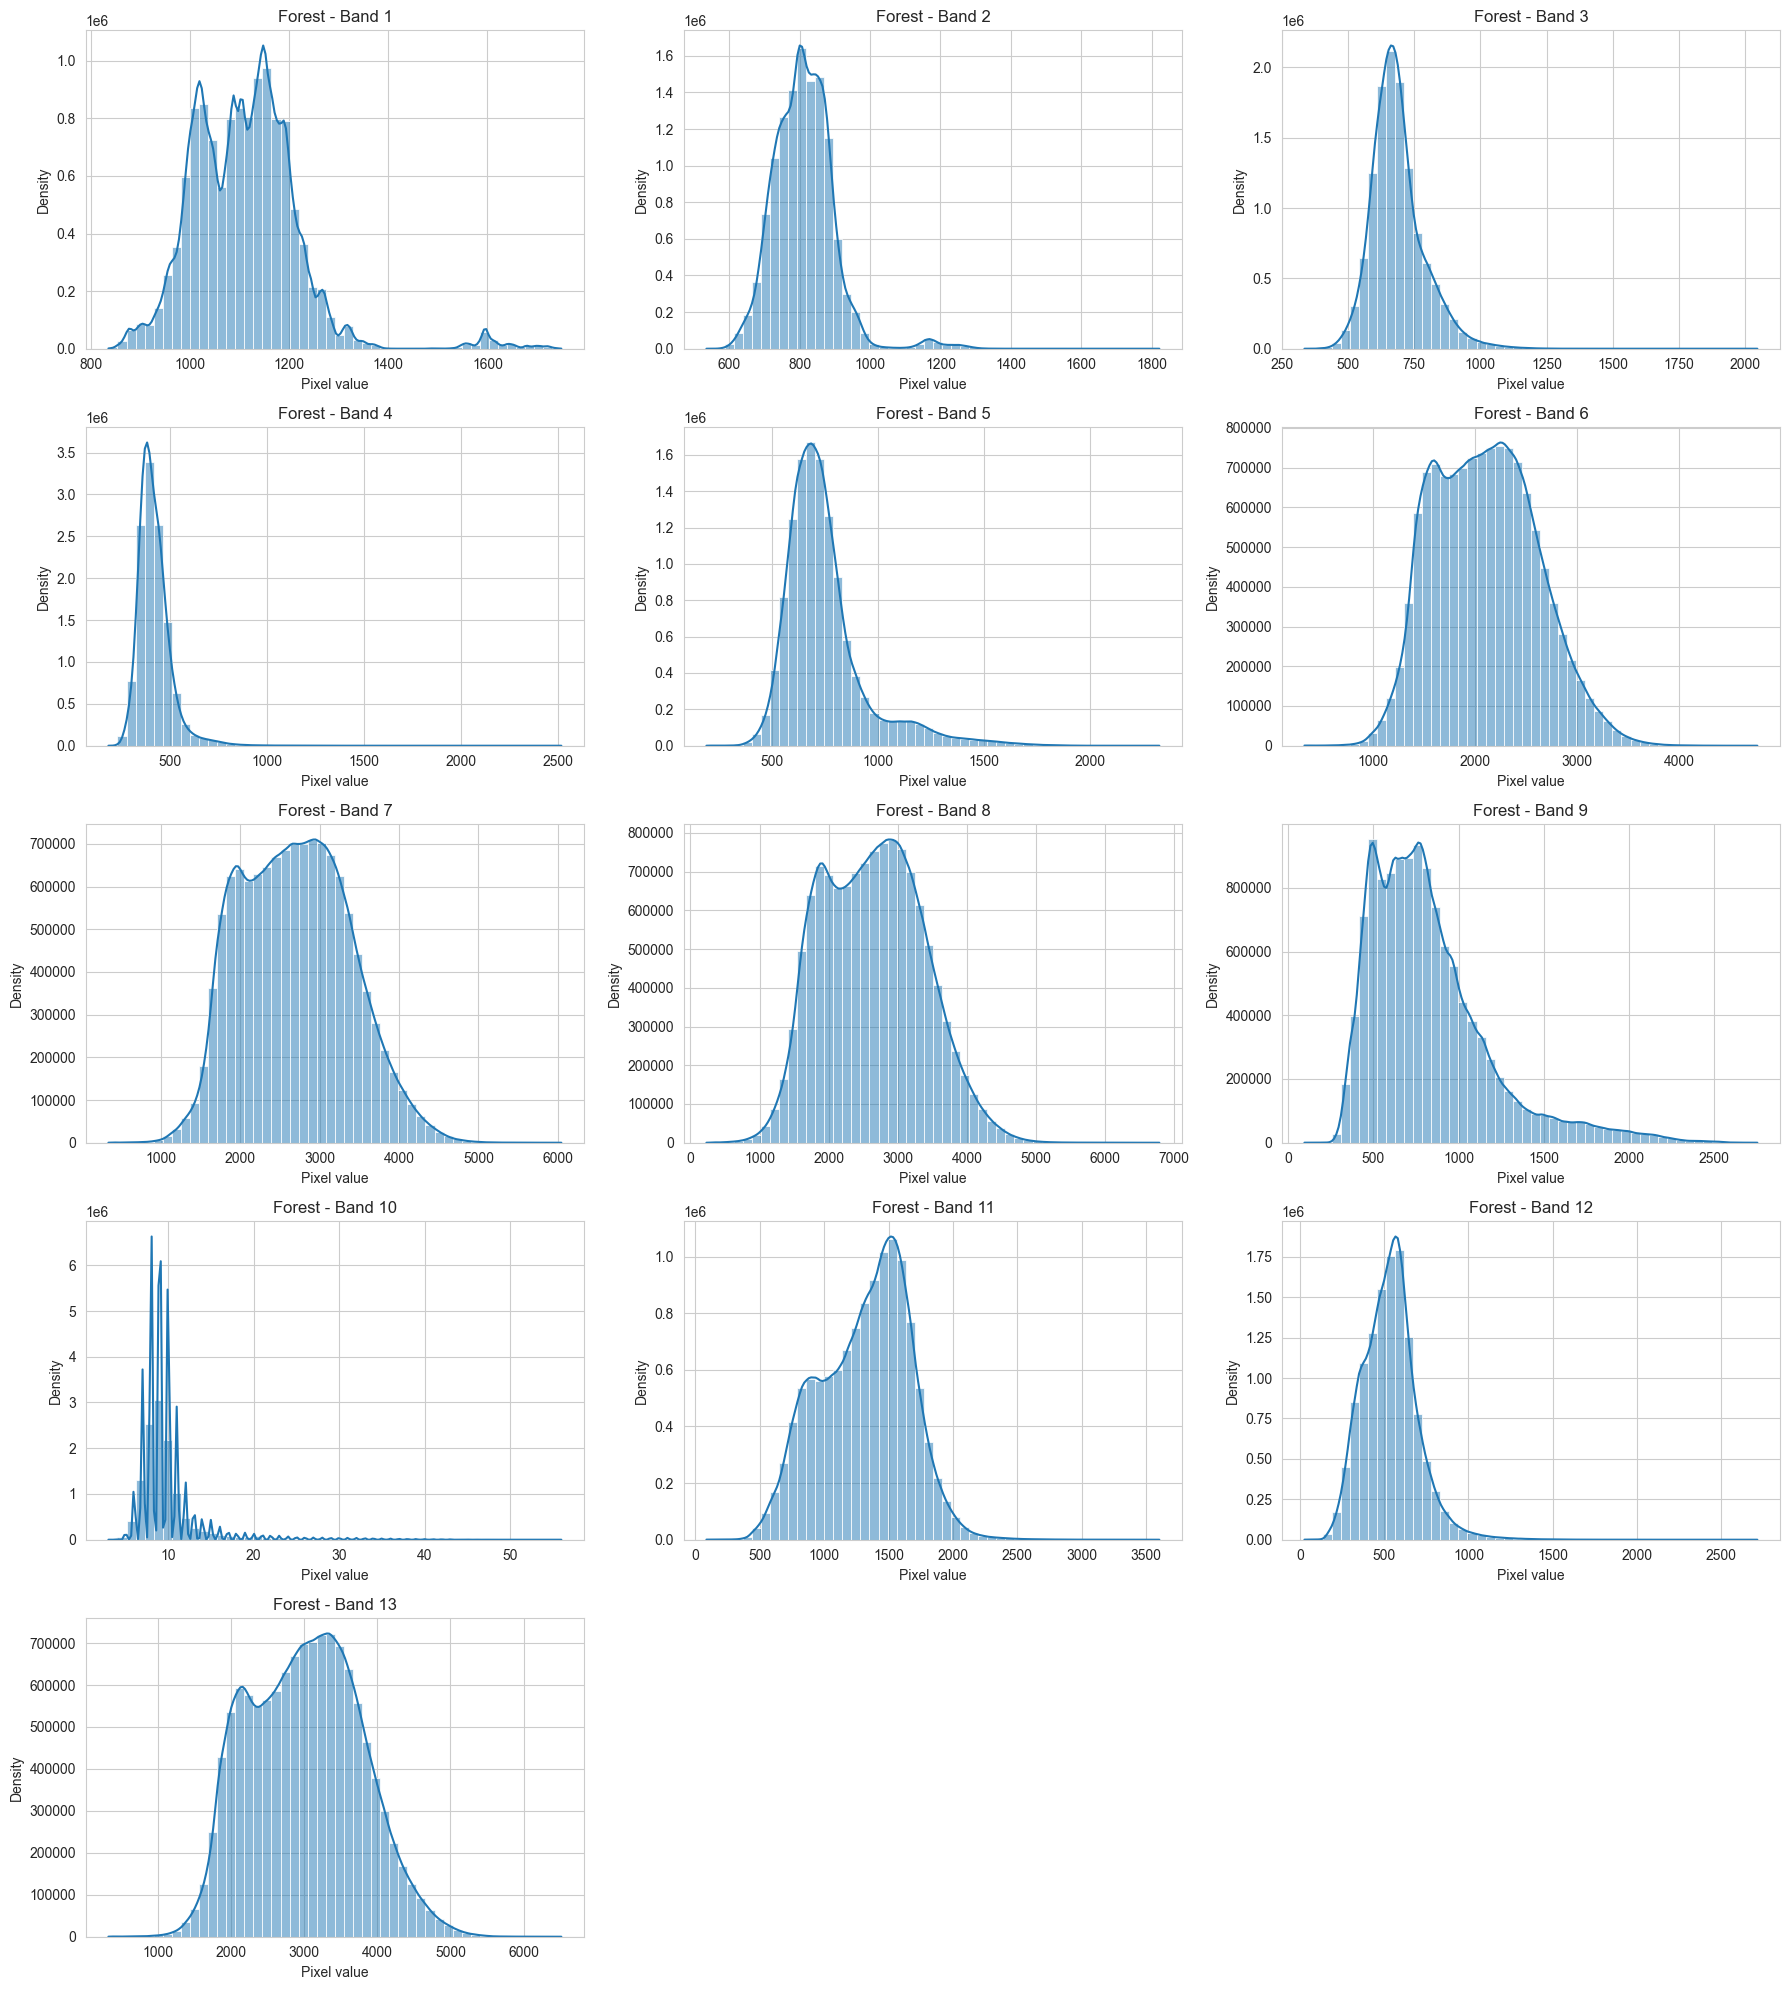

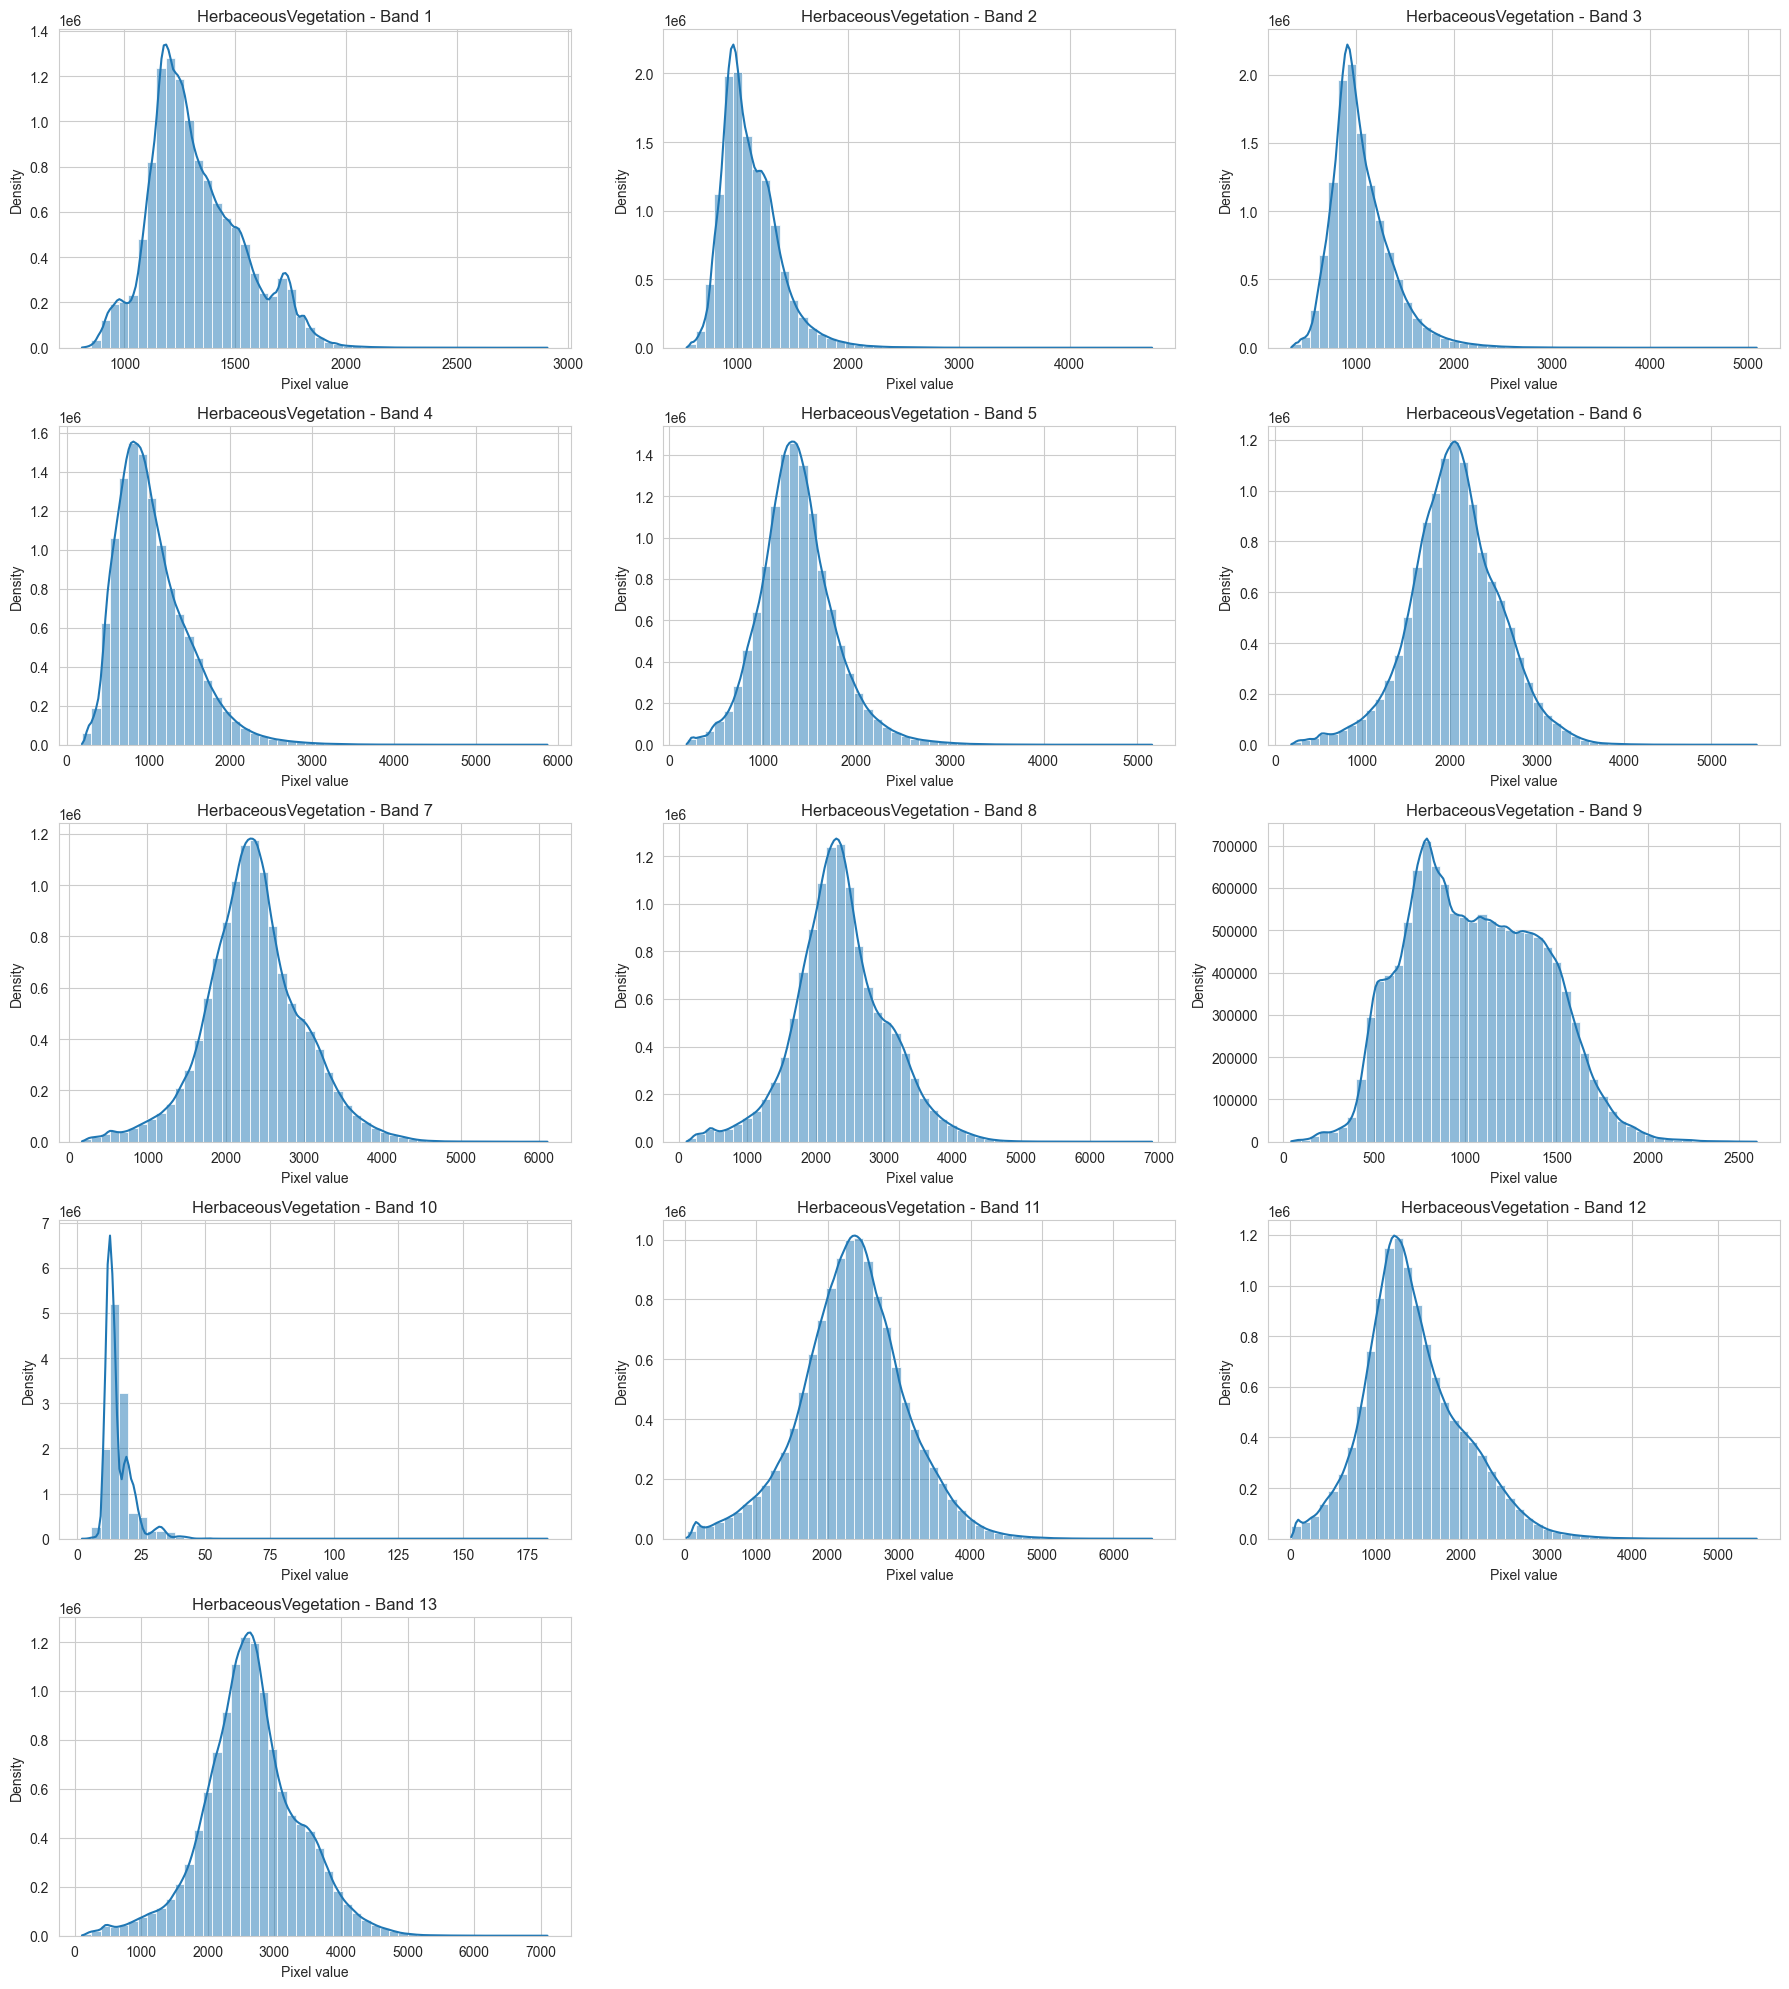

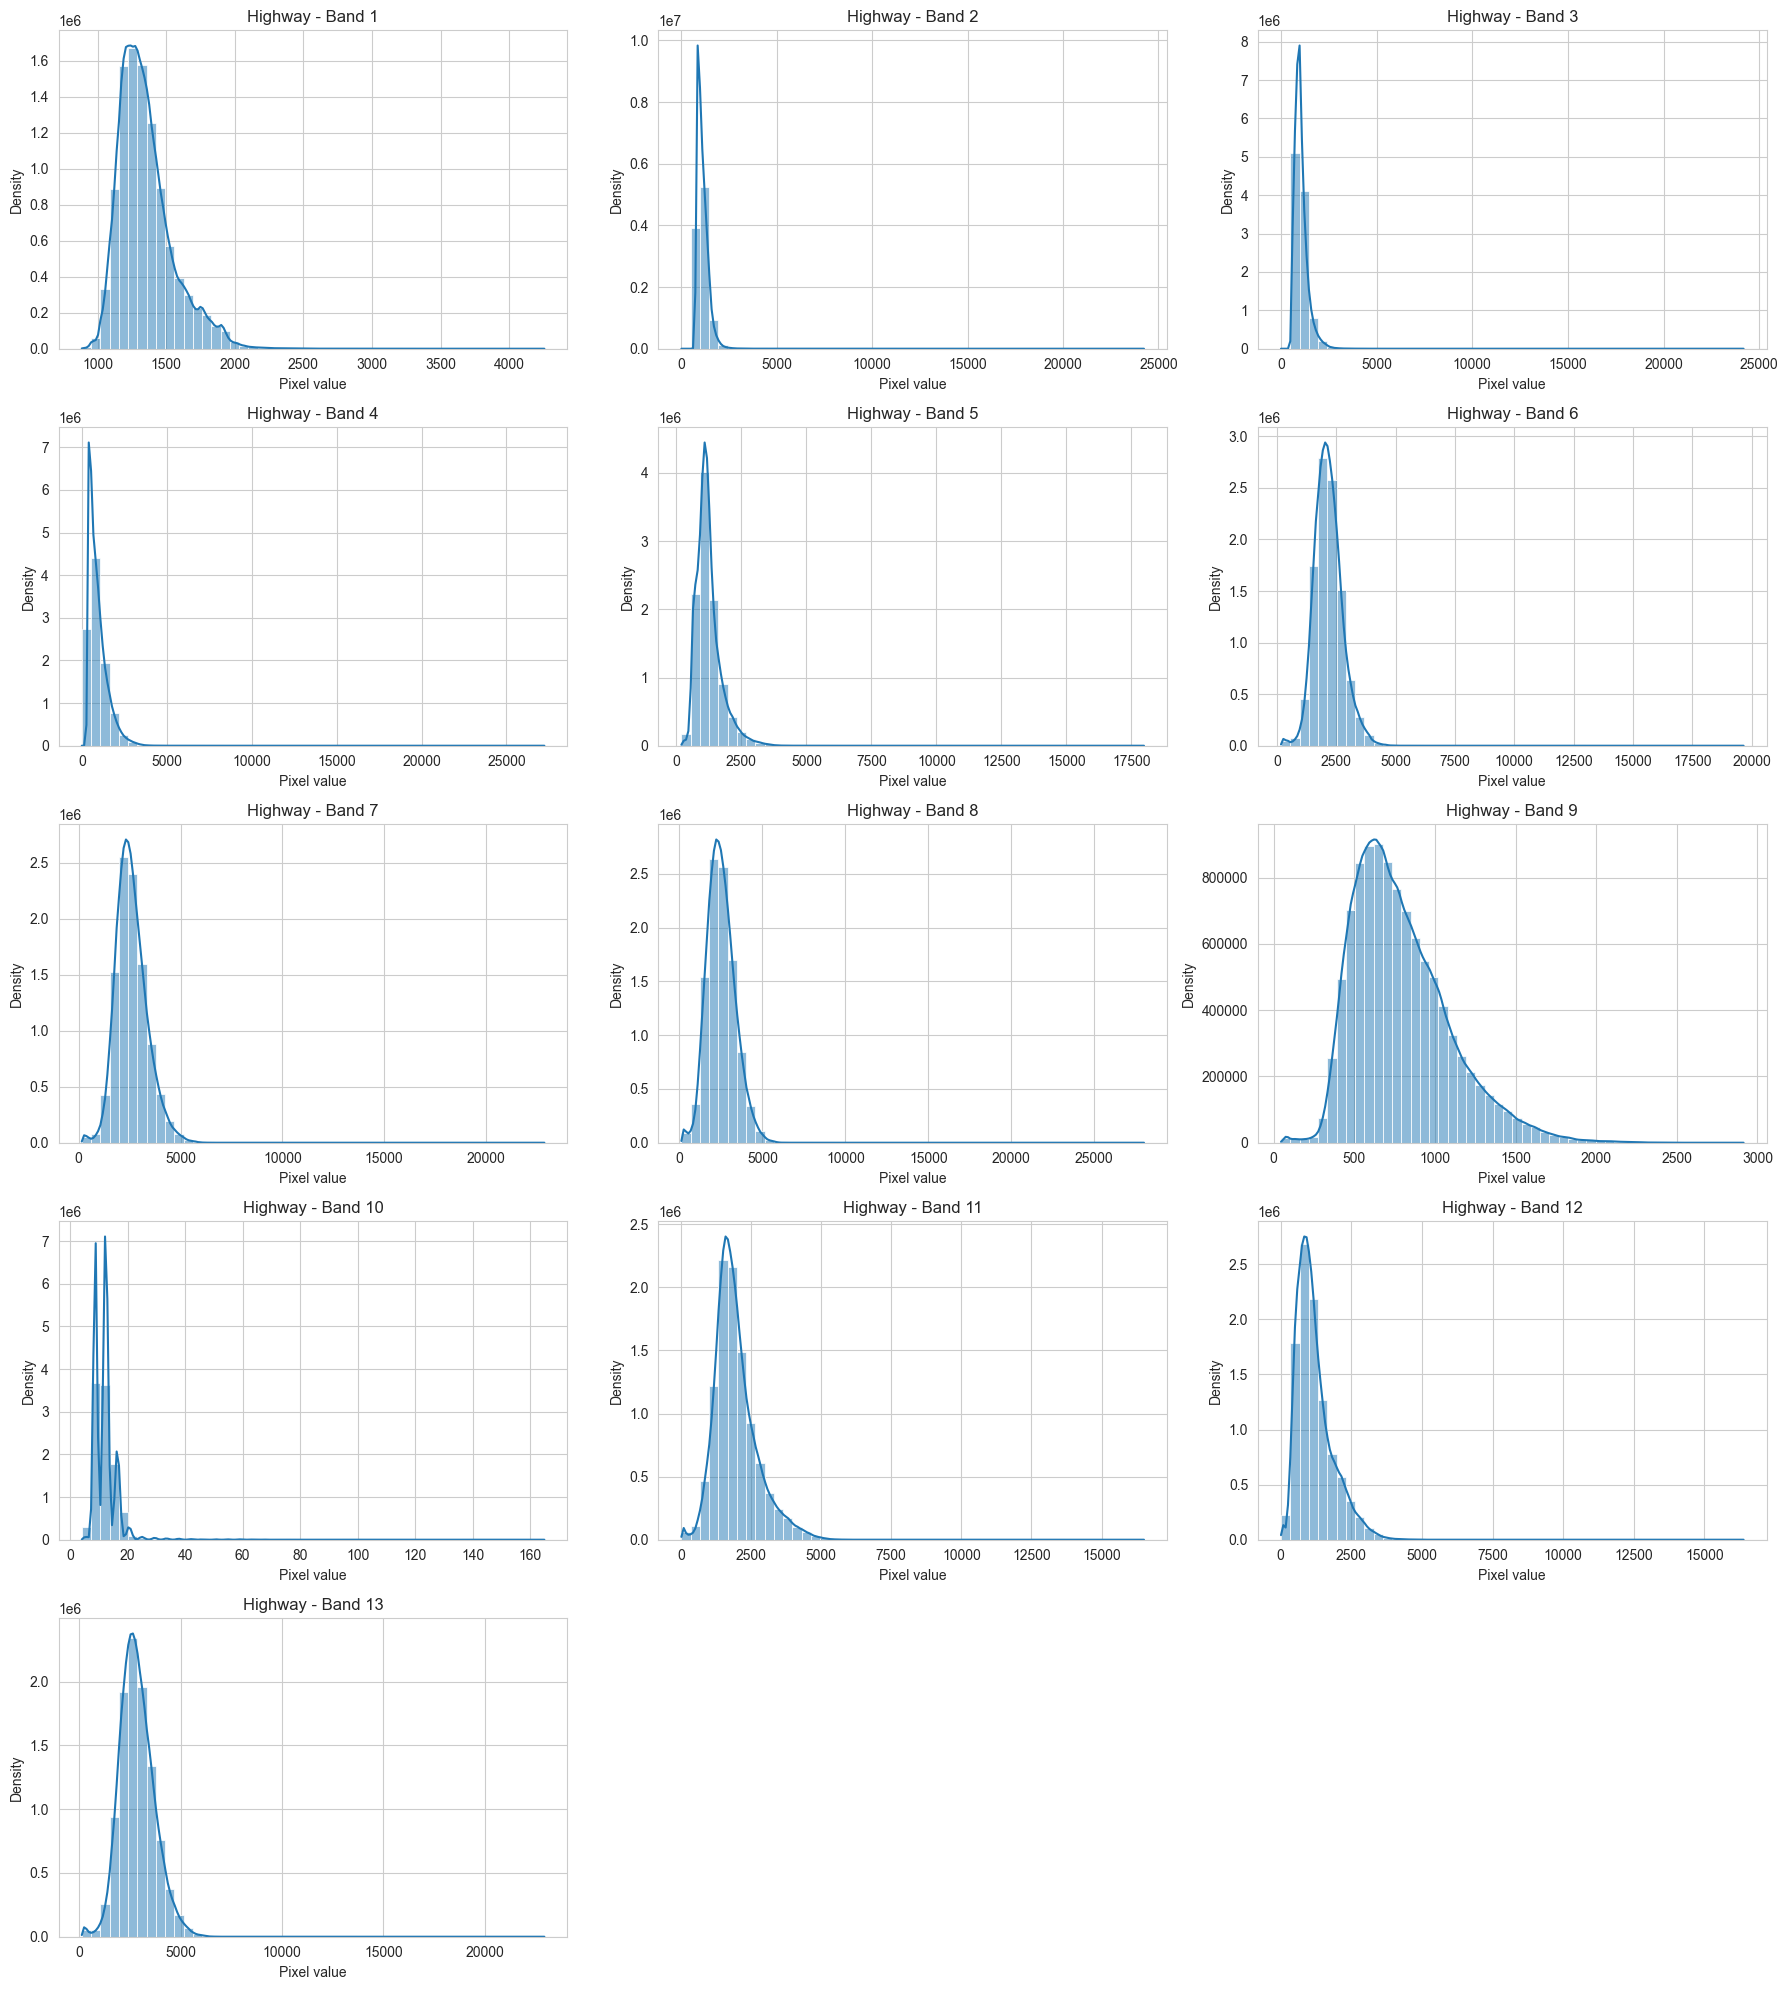

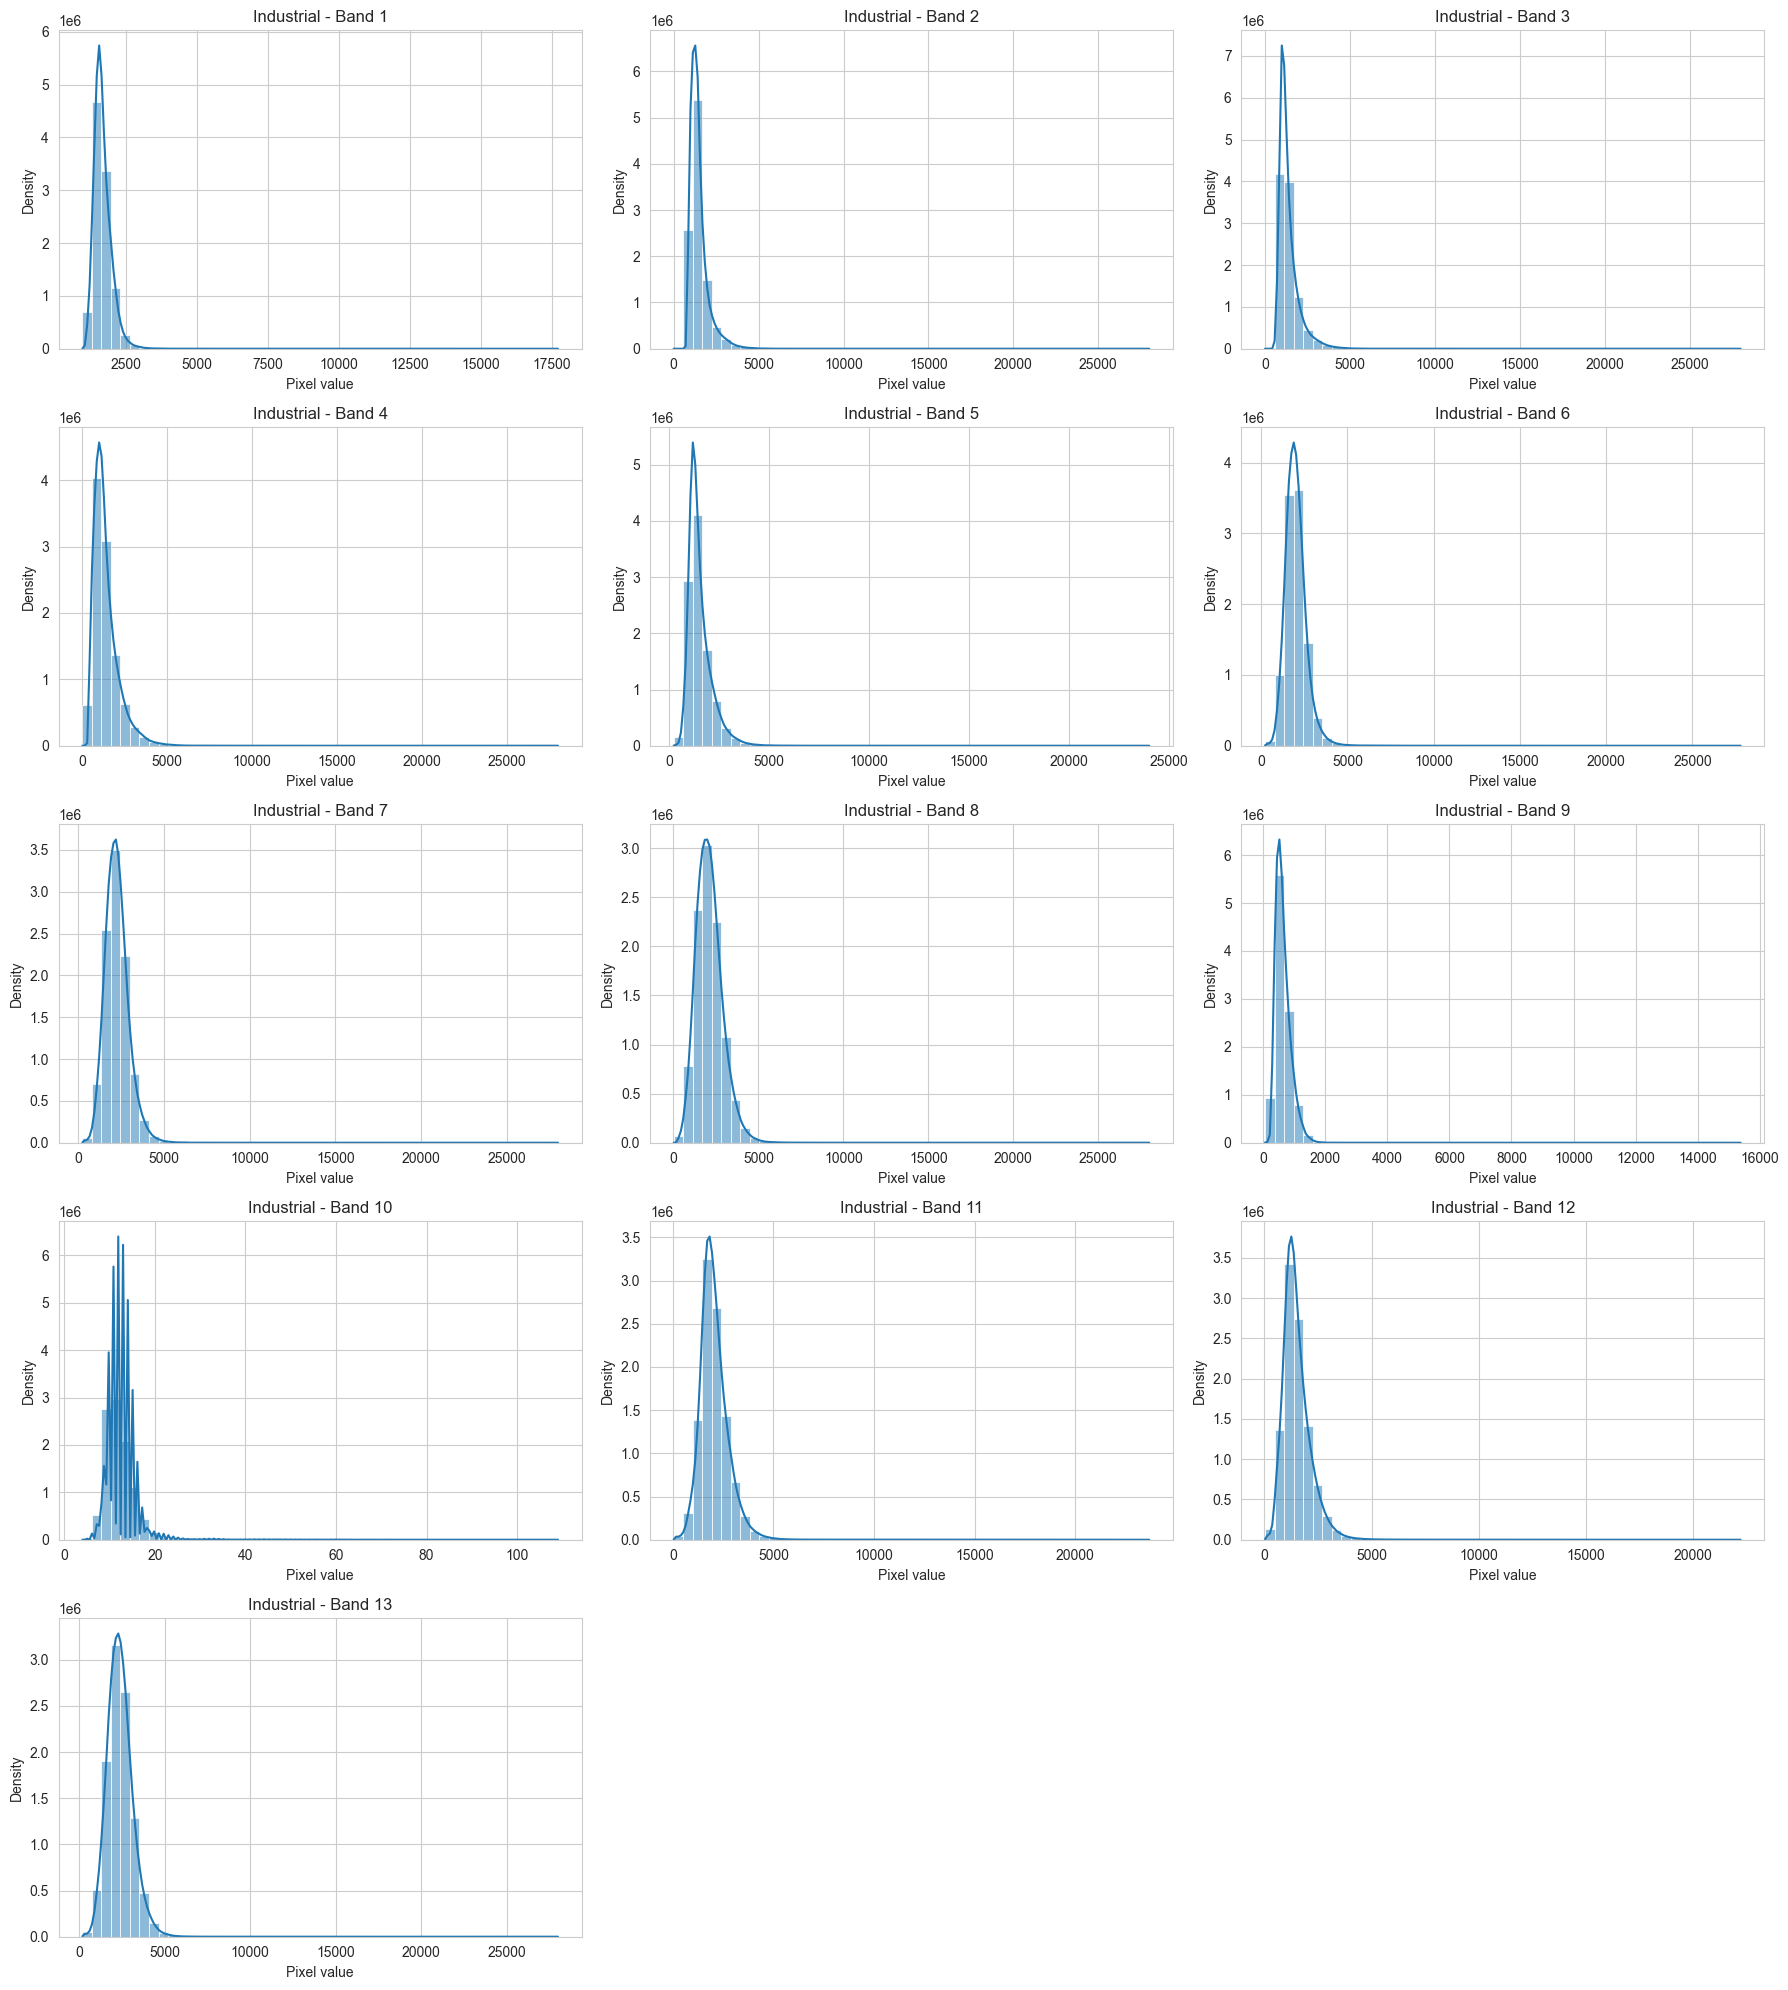

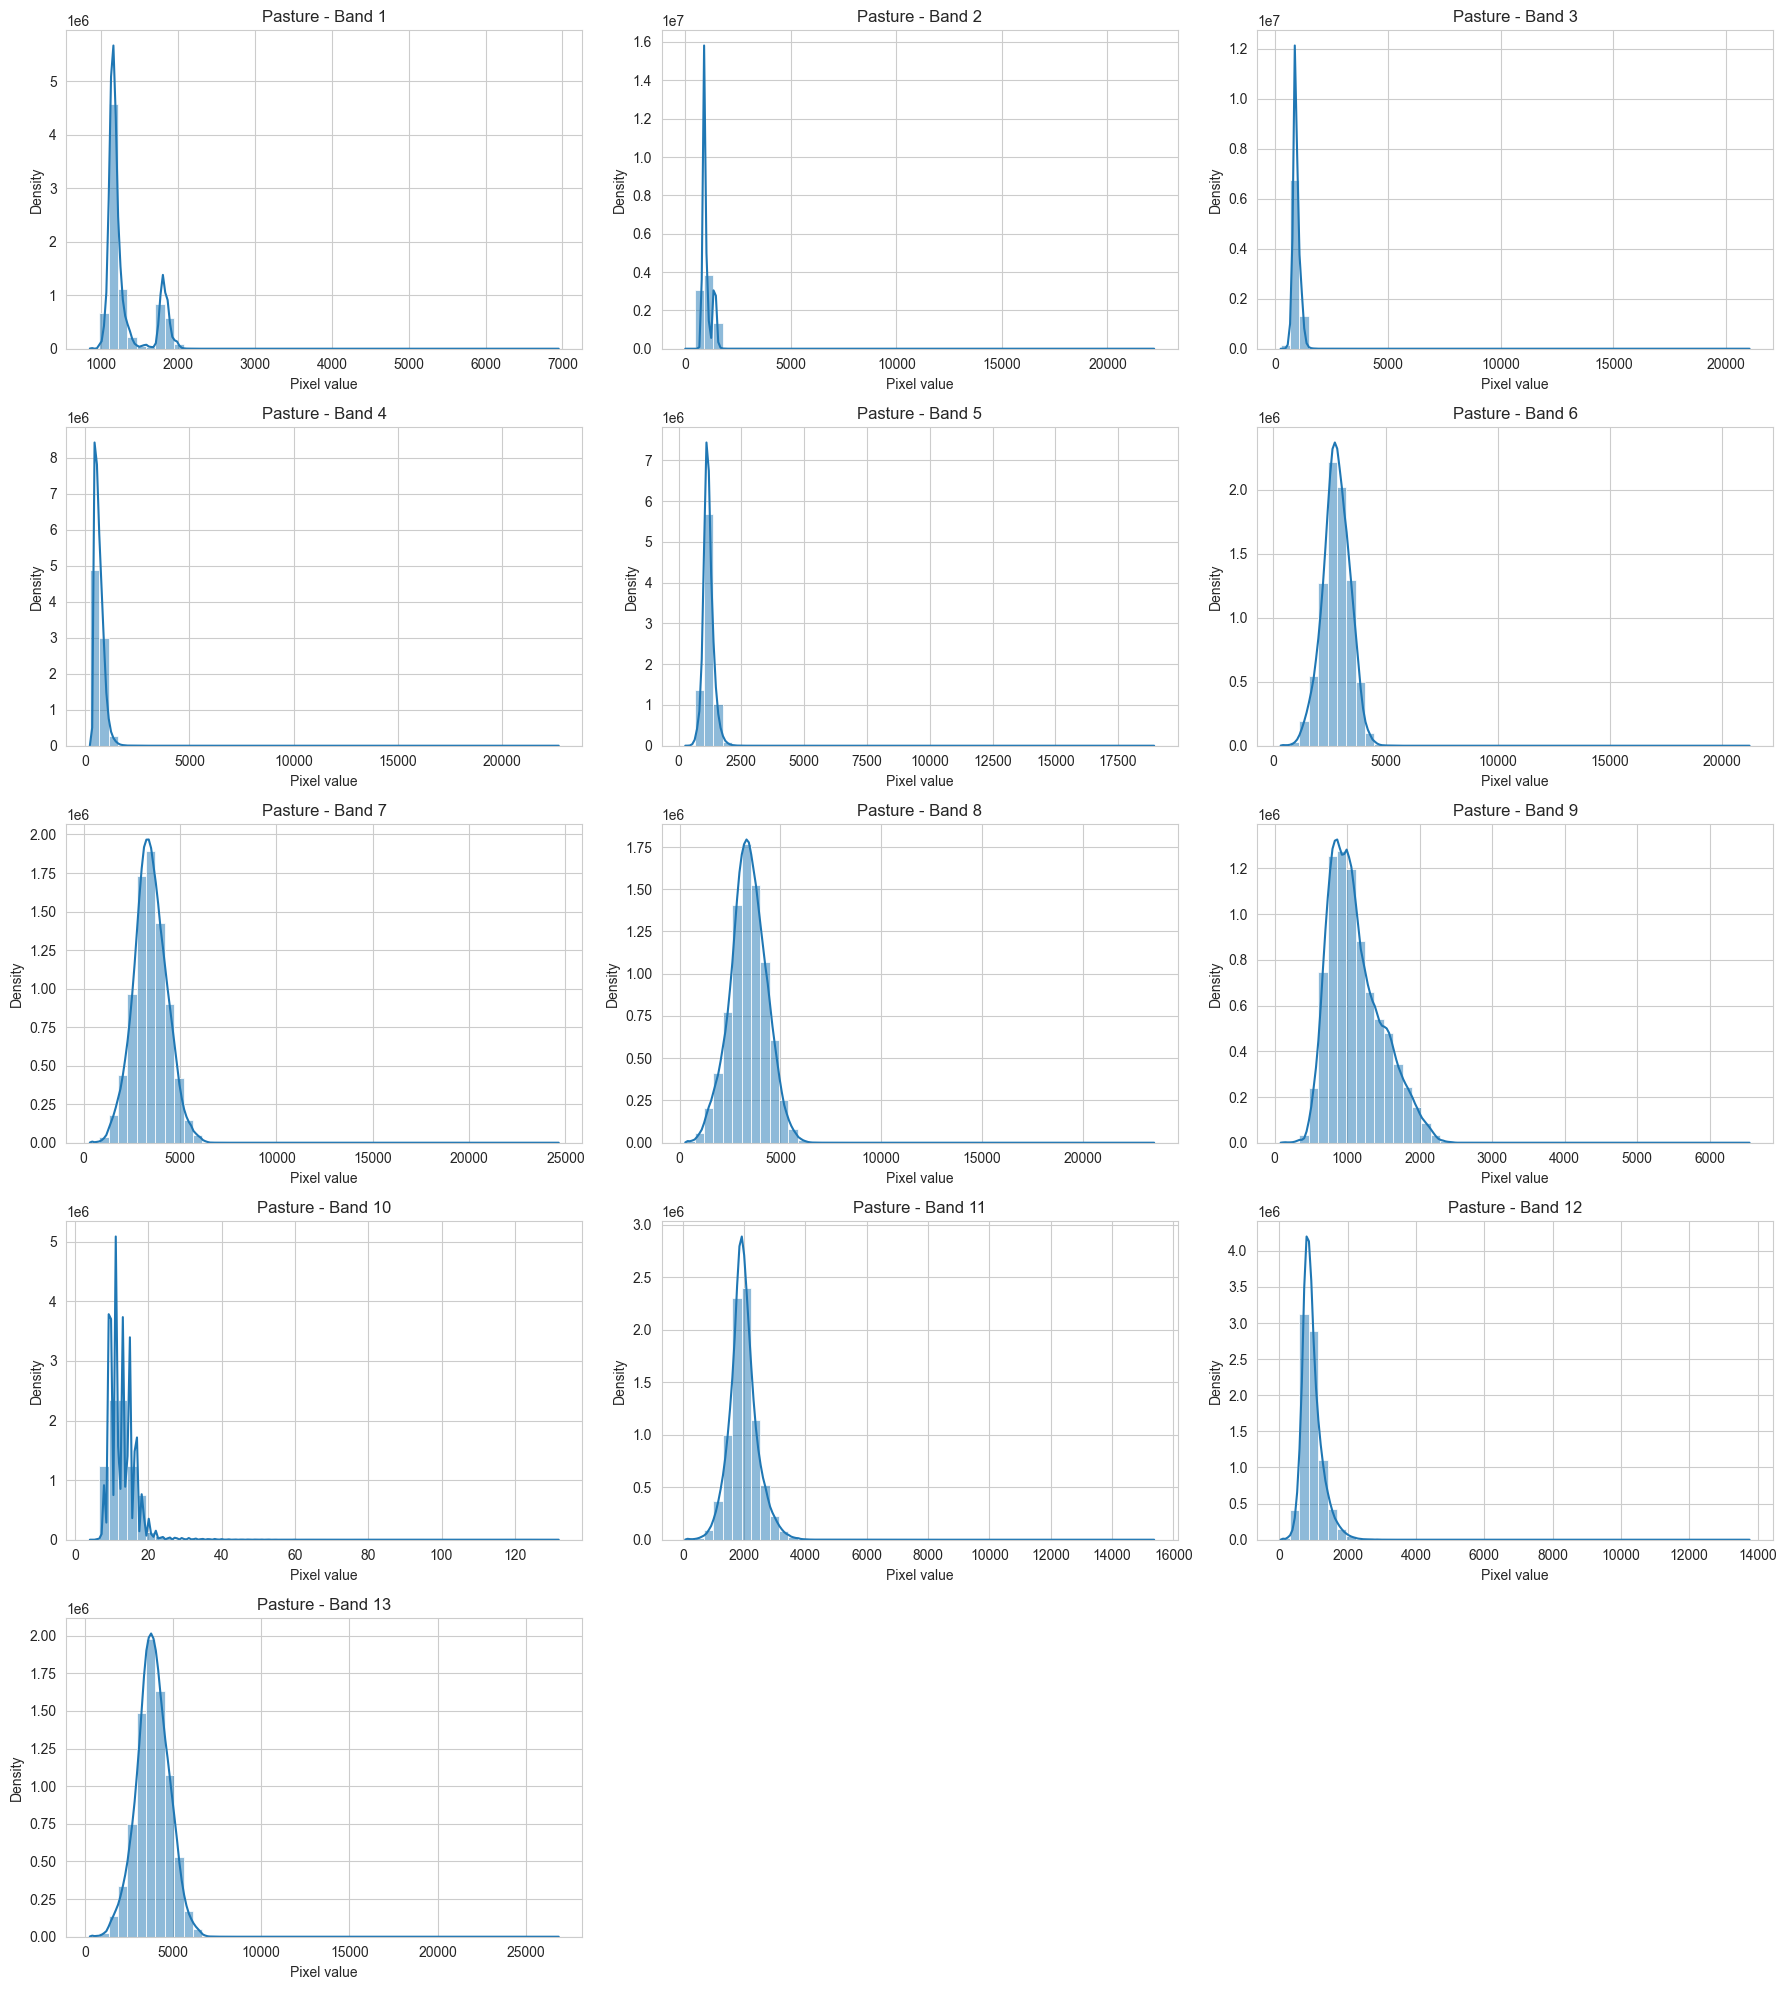

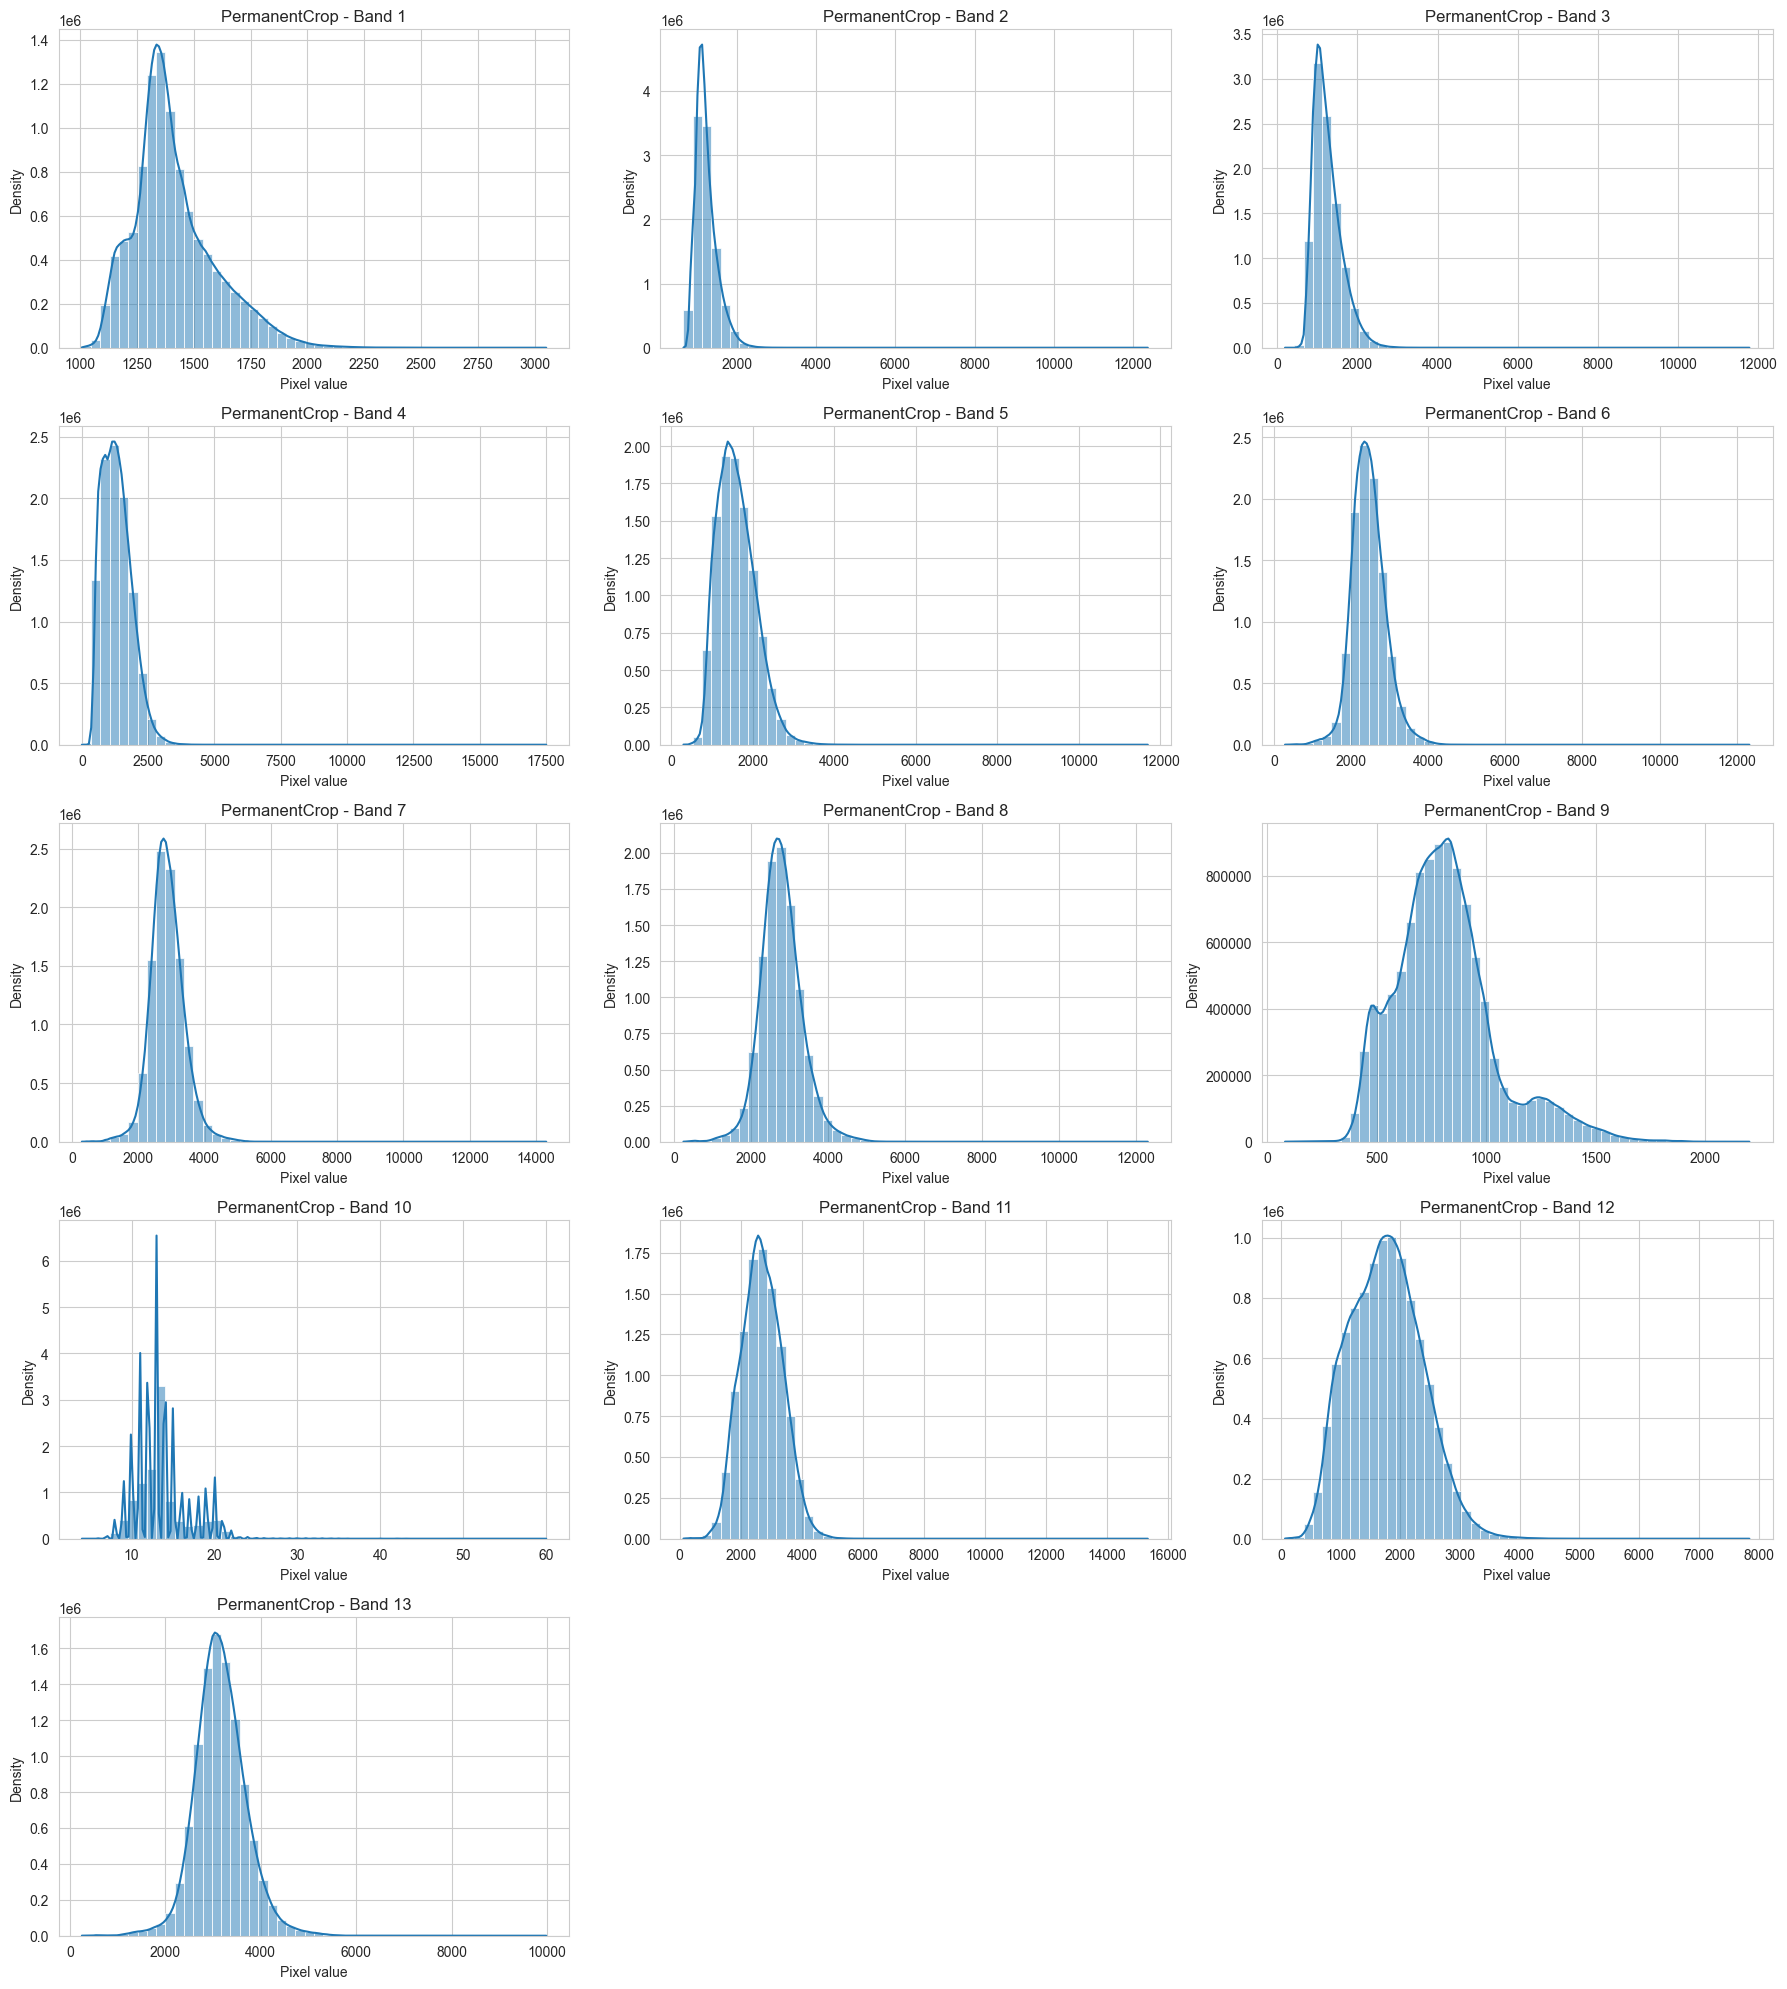

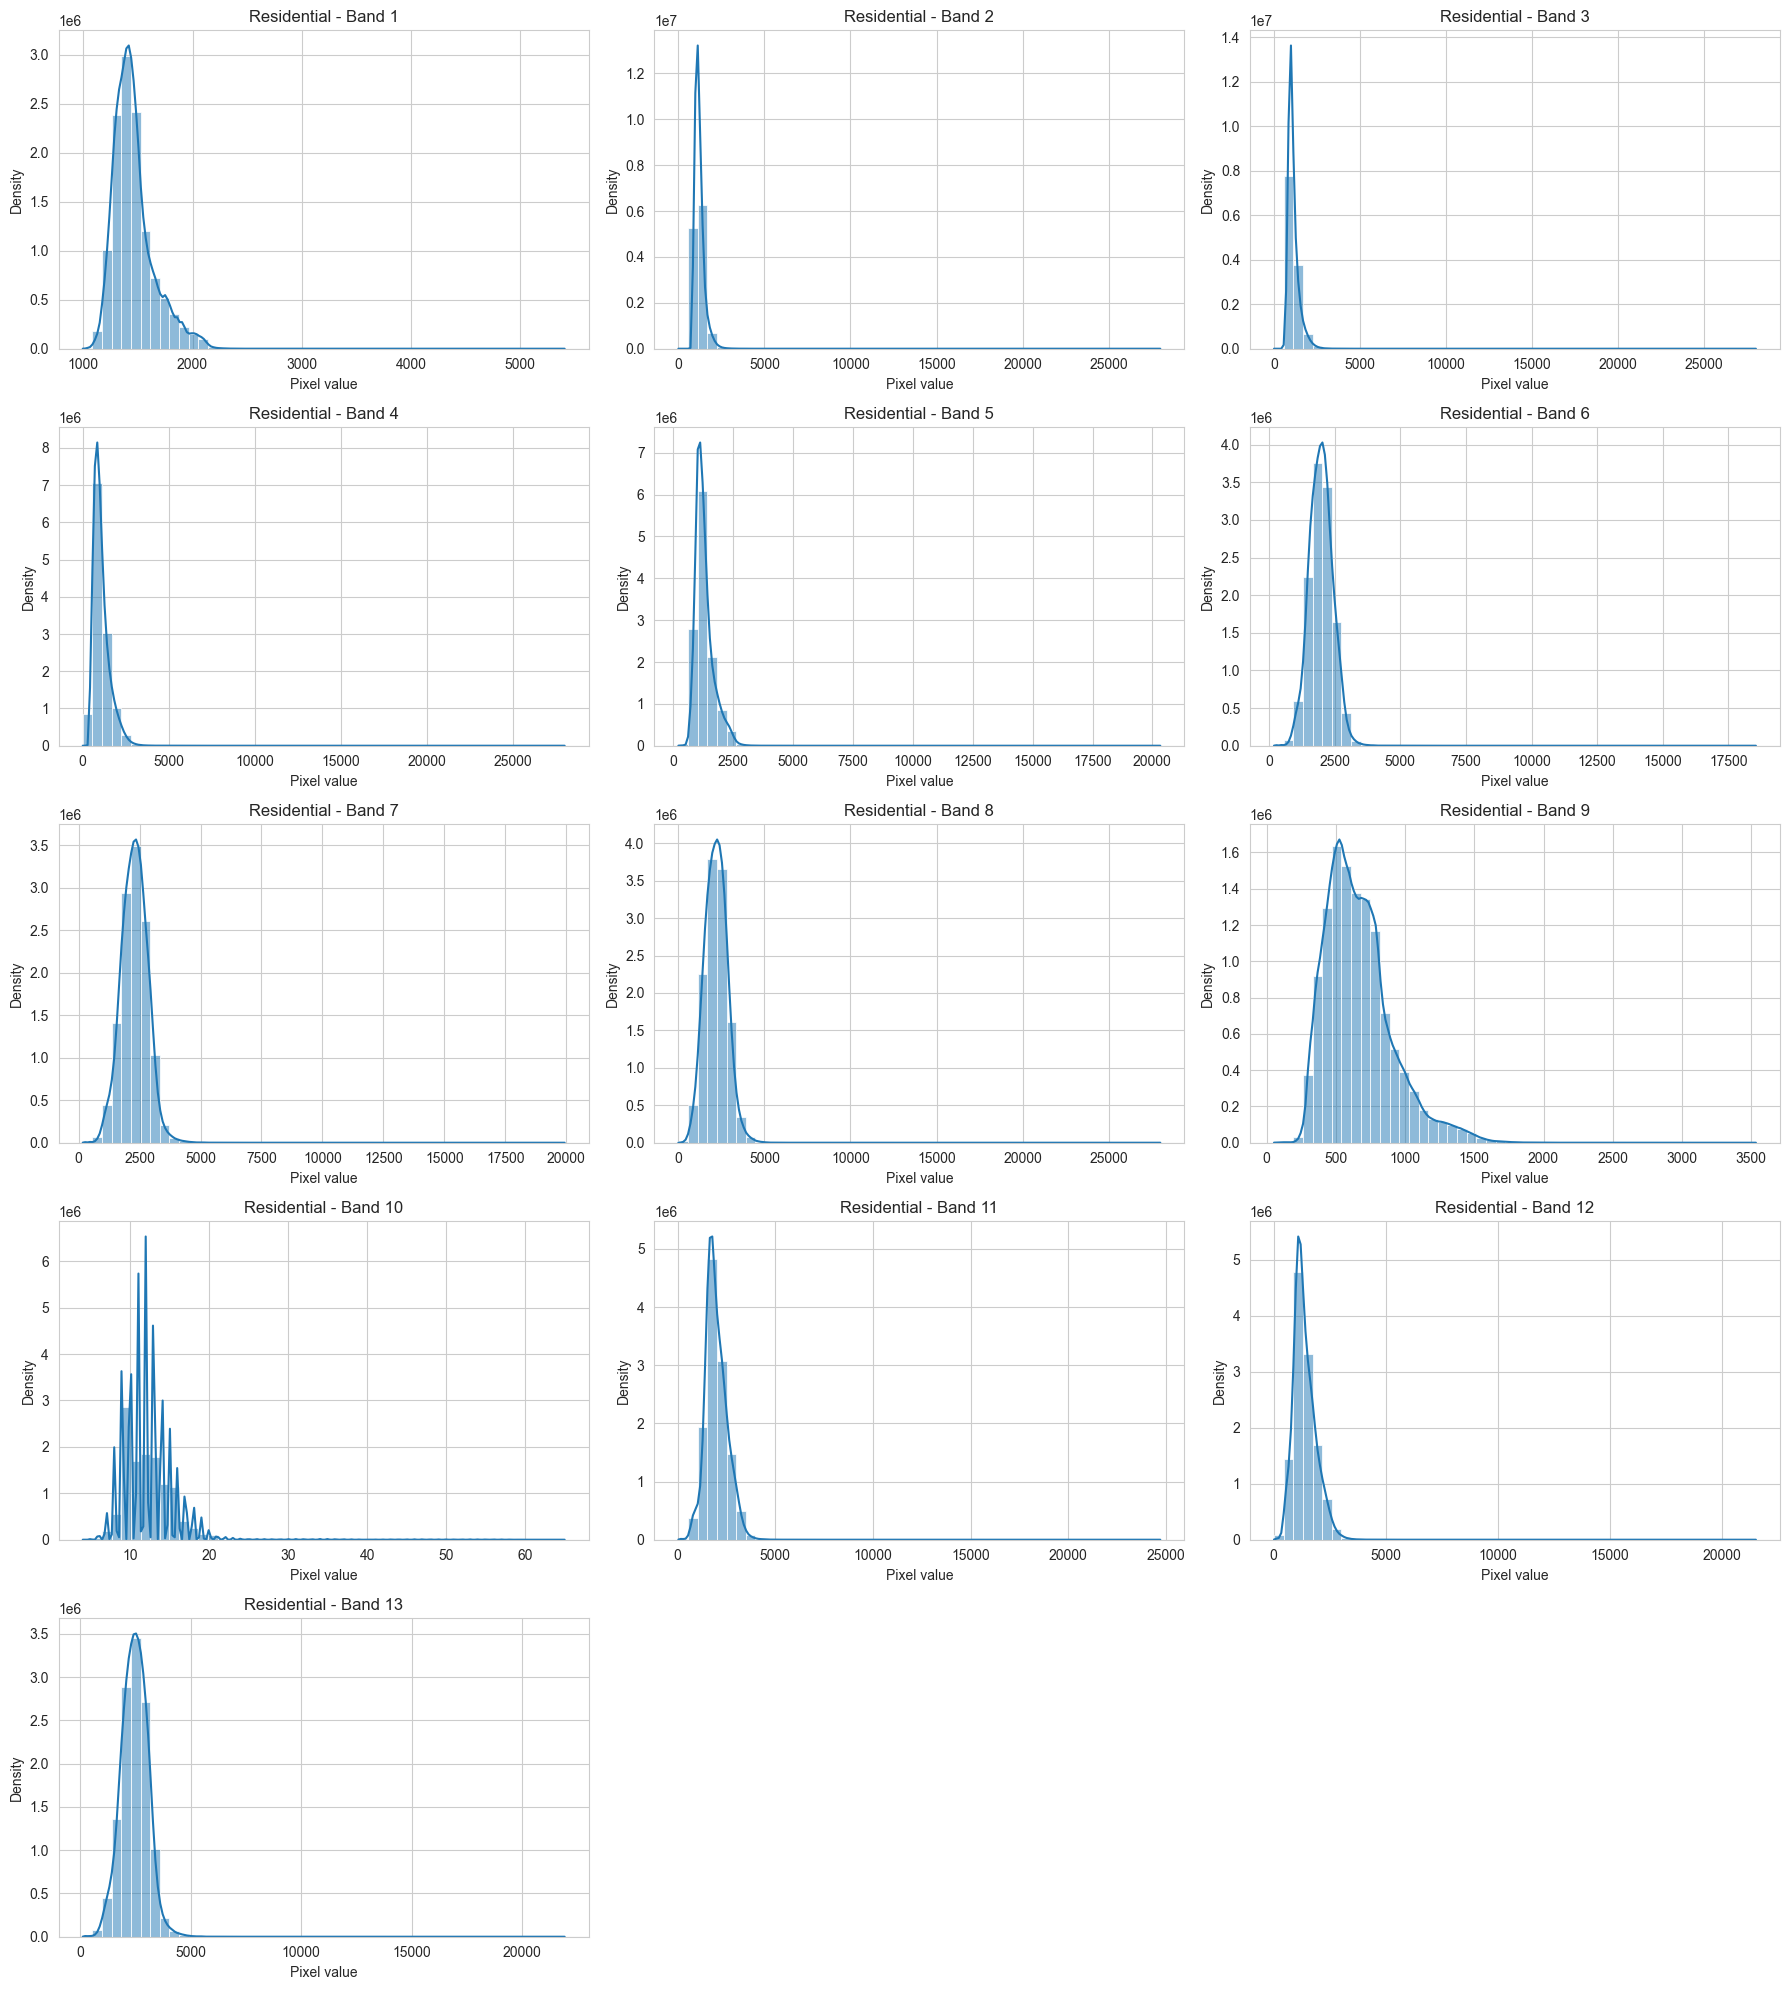

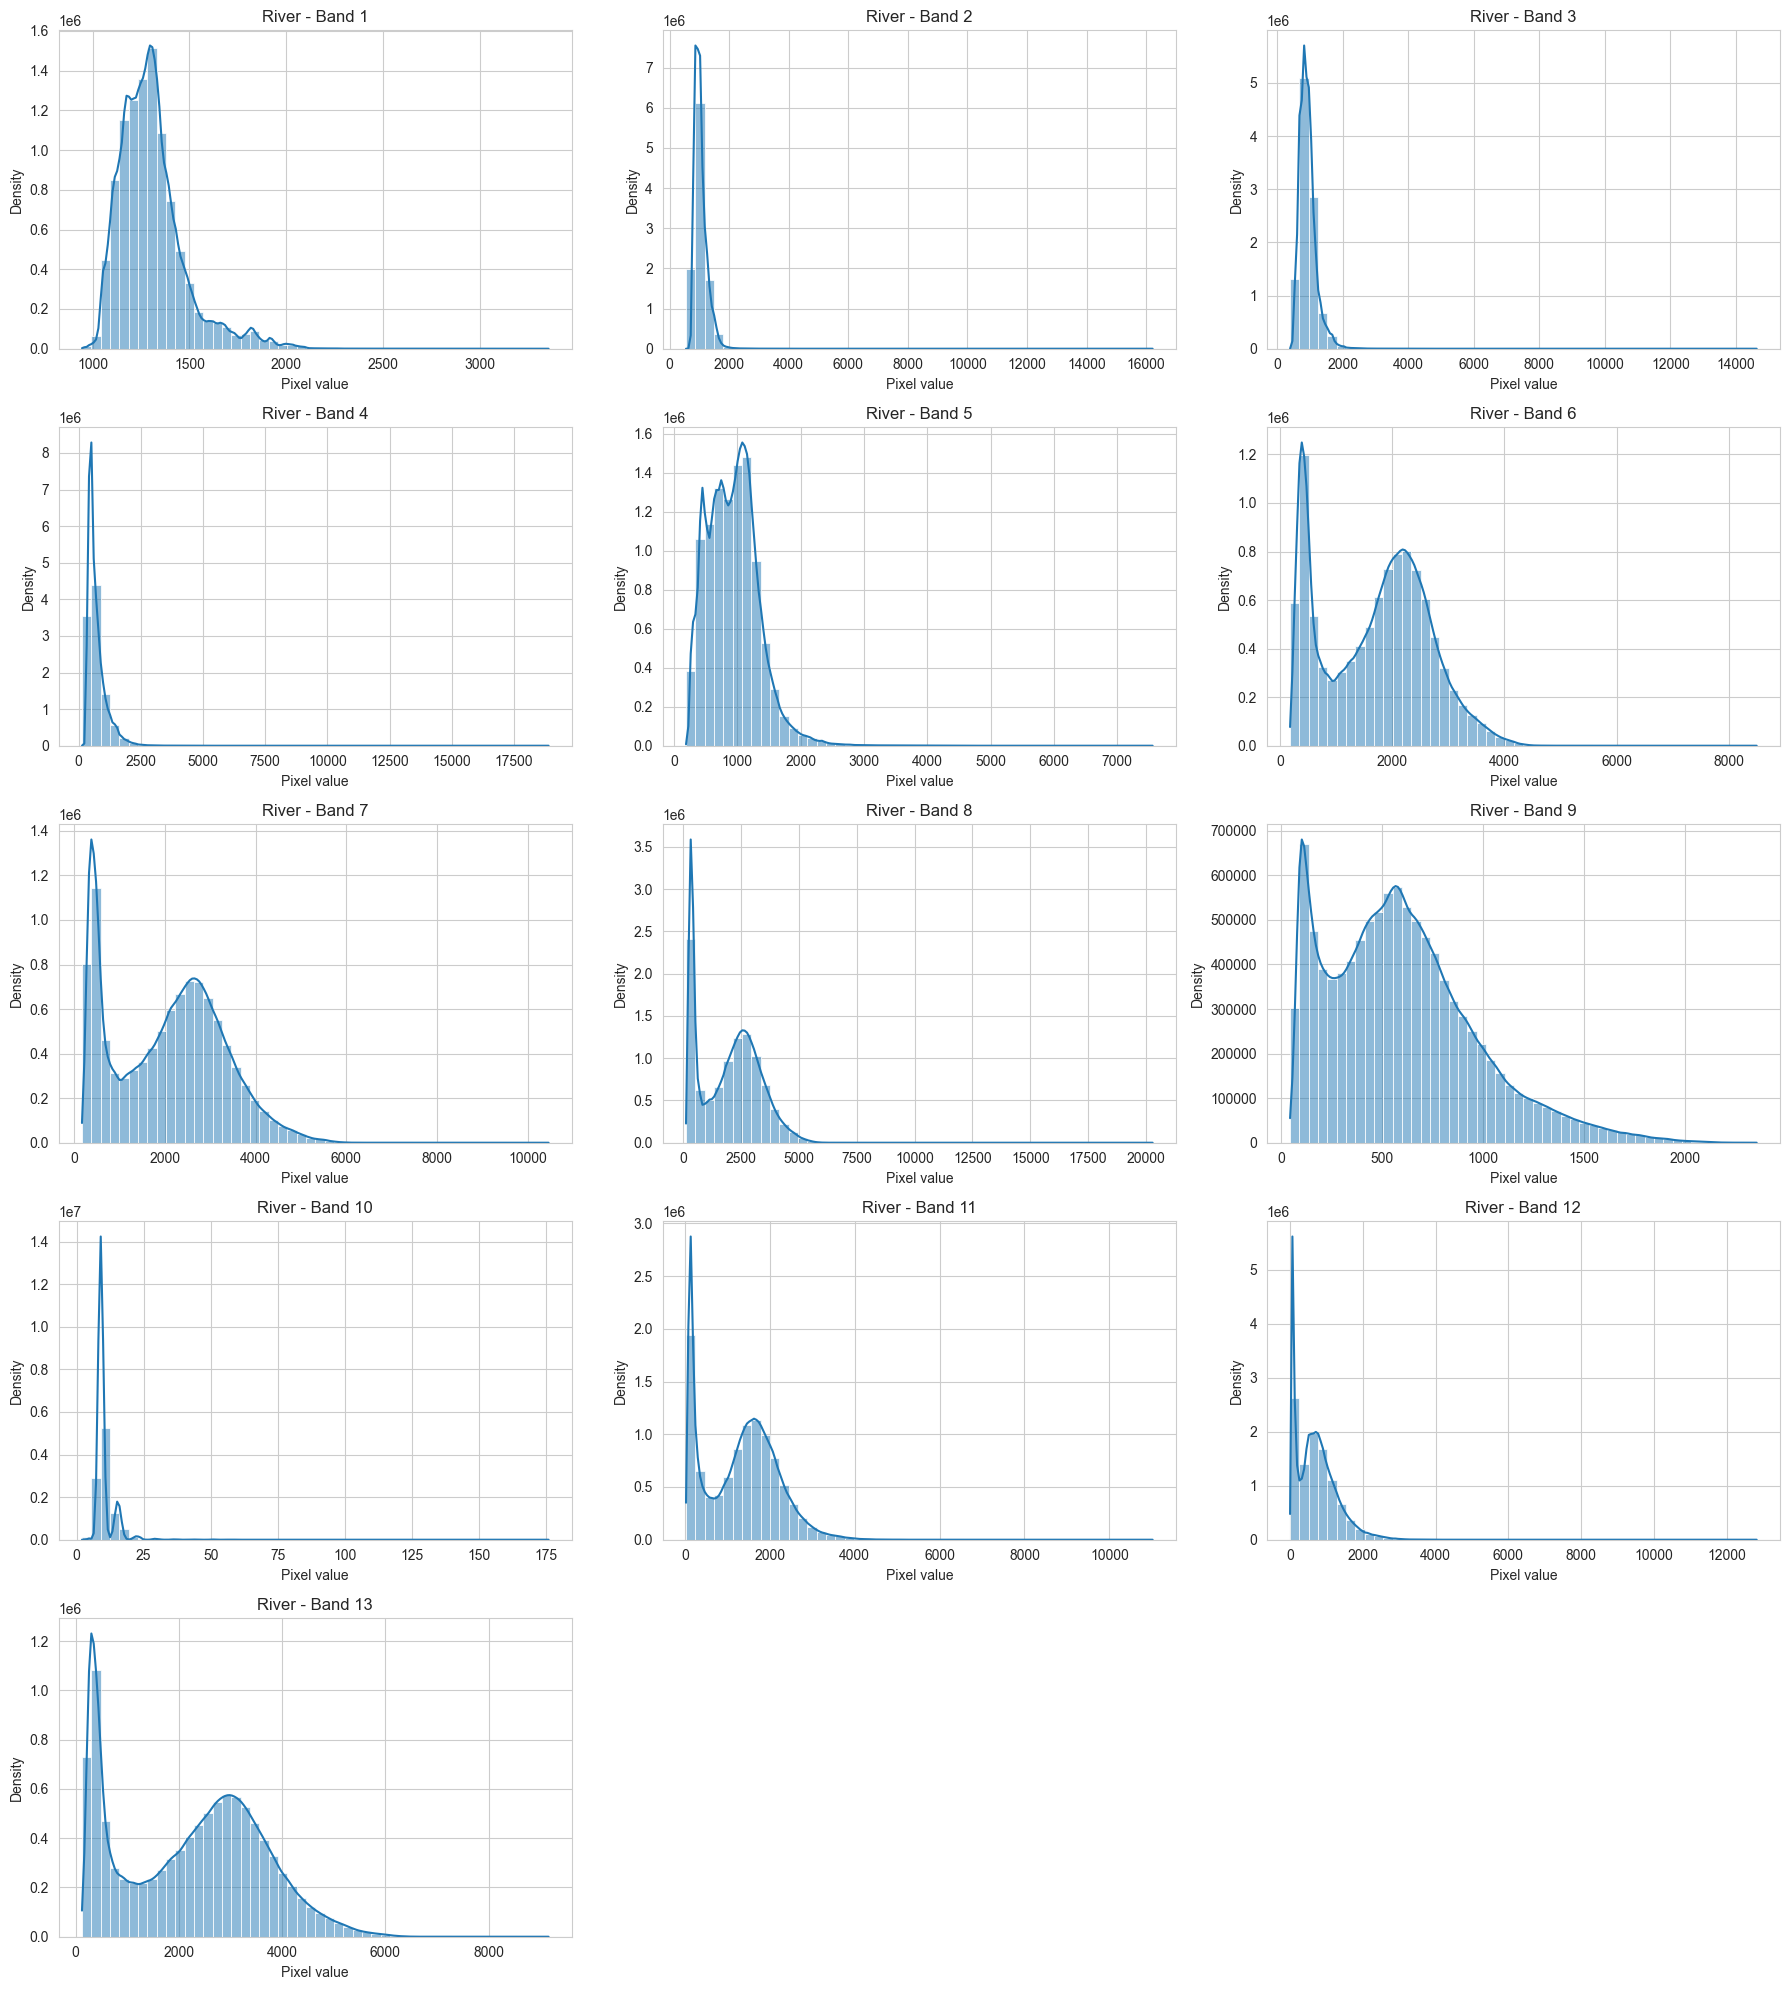

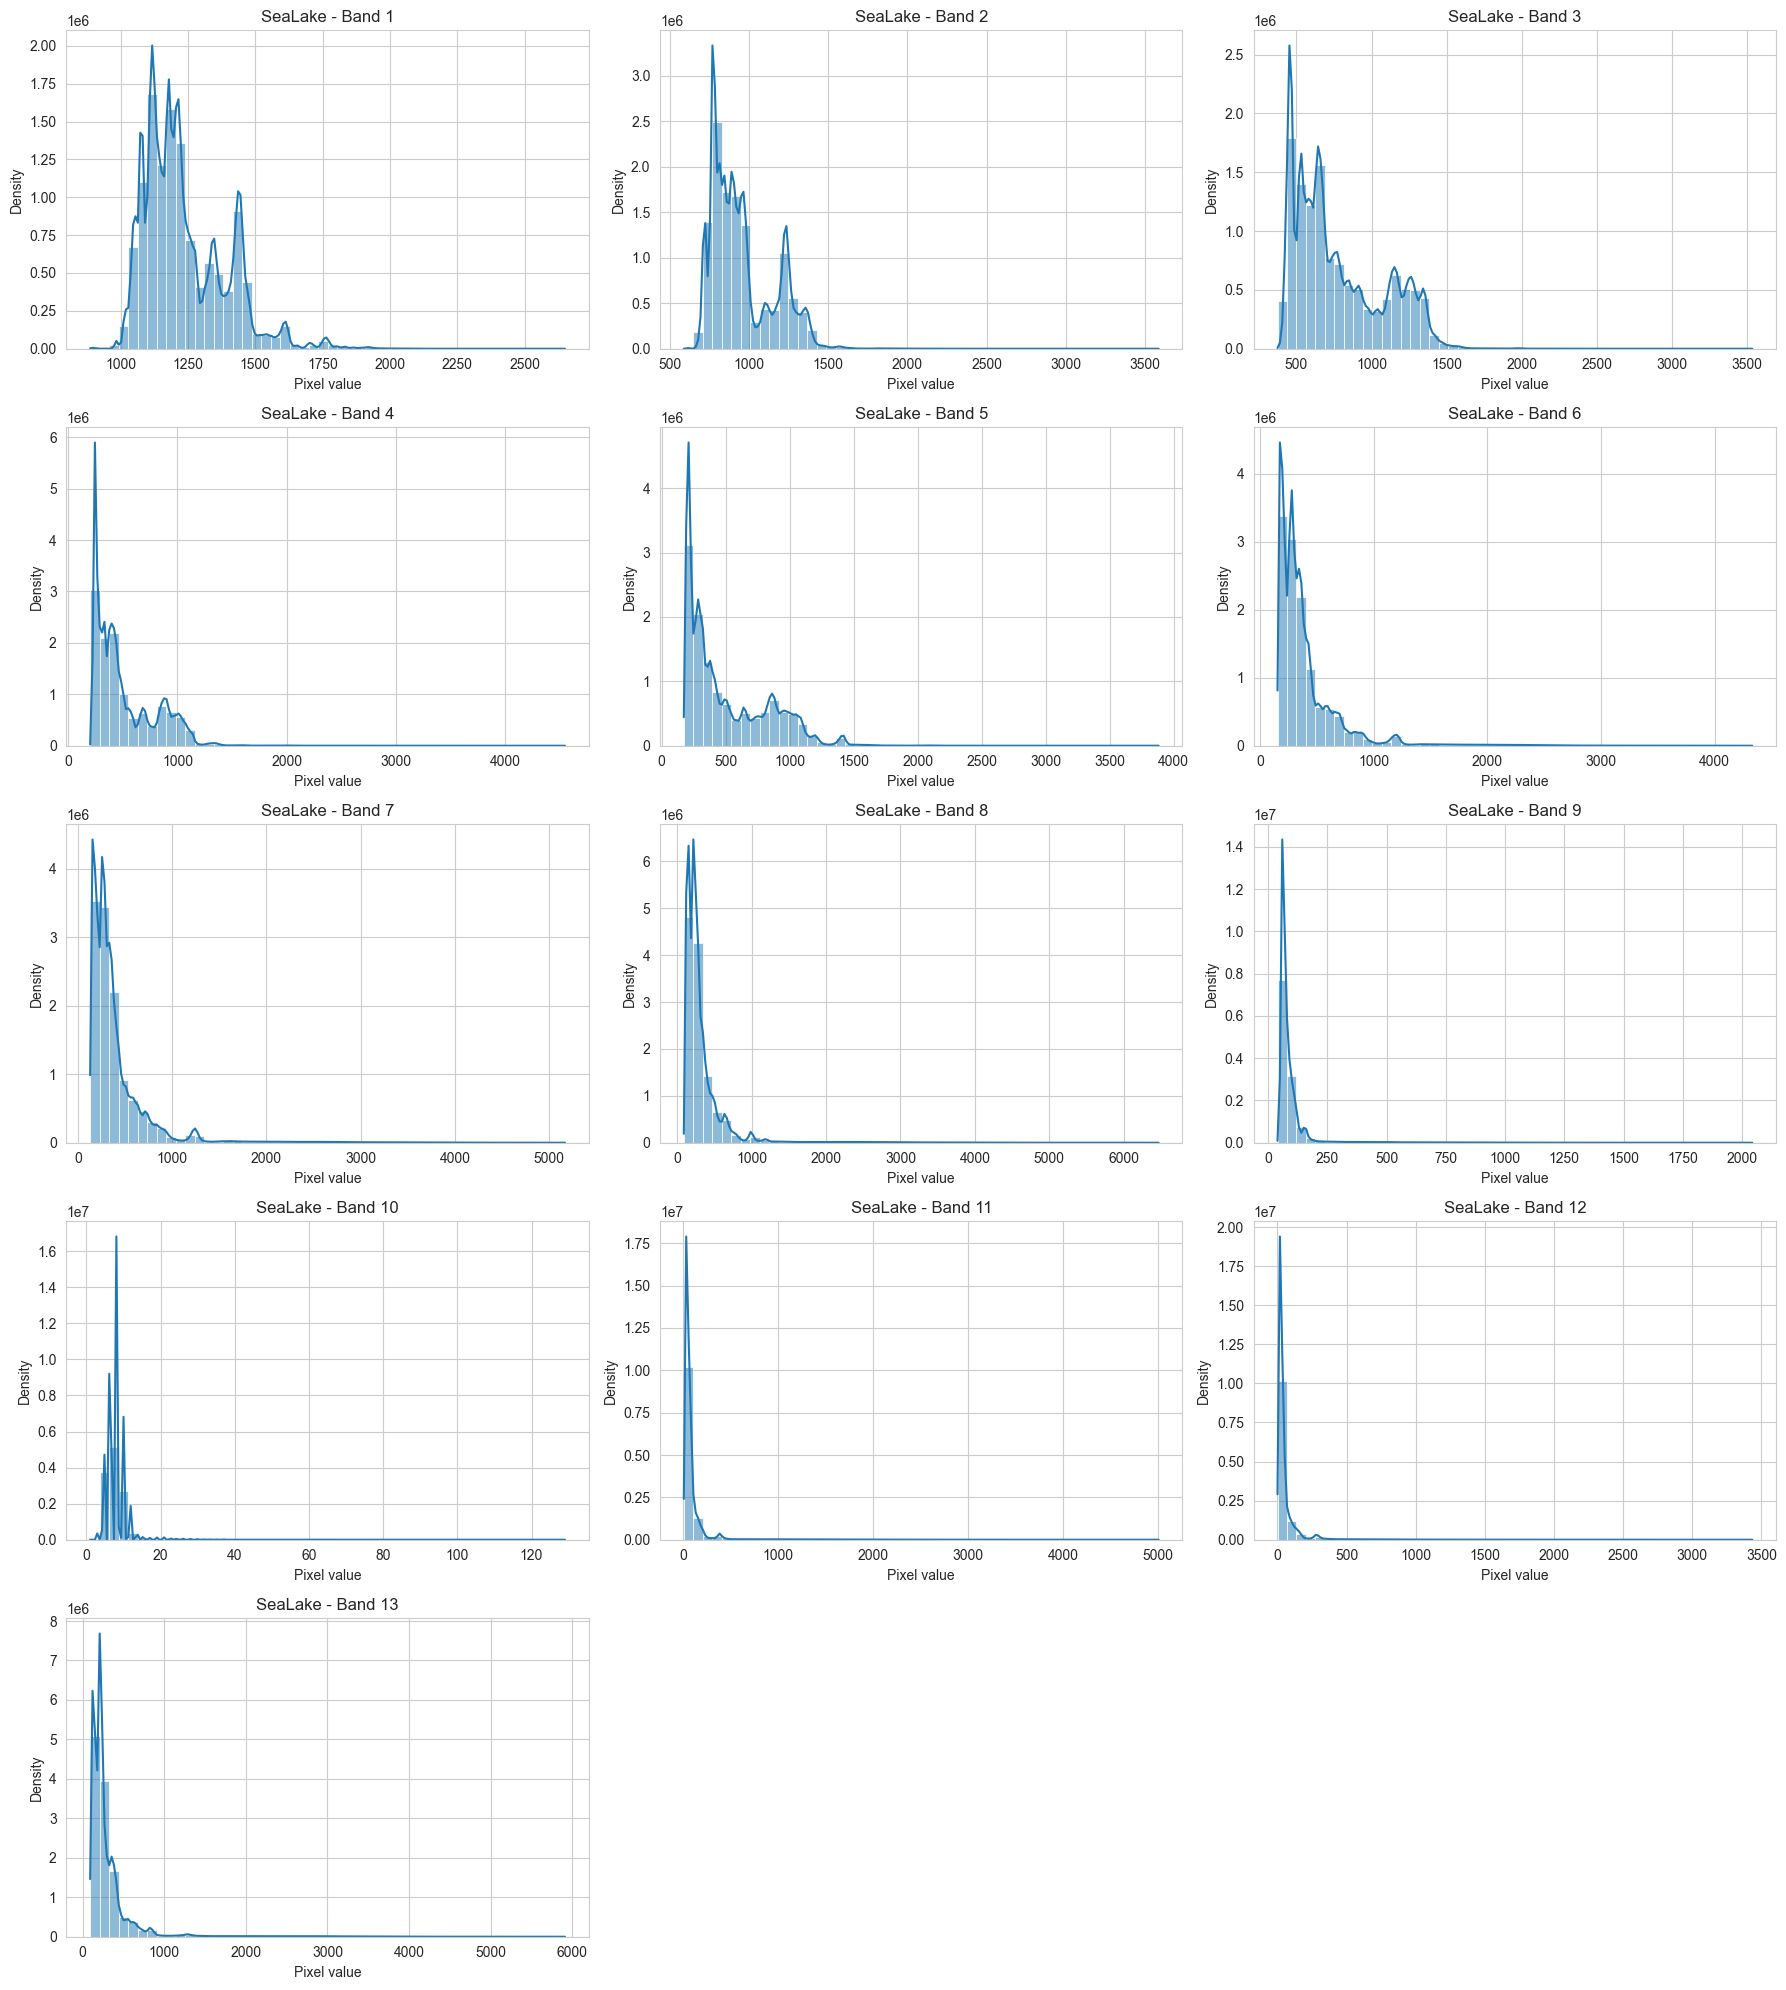

In [6]:
dataset_np = list(tfds.as_numpy(train_ds))

sns.set_style("whitegrid")

for class_idx, class_name in enumerate(class_names):
    class_imgs = [img.astype(np.float32) for img, label in dataset_np if label == class_idx]
    if len(class_imgs) == 0:
        continue

    samples_array = np.stack(class_imgs)
    num_bands = samples_array.shape[-1]
    band_values = [samples_array[..., b].flatten() for b in range(num_bands)]

    fig, axes = plt.subplots(5, 3, figsize=(18, 20))
    axes = axes.flatten()

    for b in range(num_bands):
        ax = axes[b]
        sns.histplot(band_values[b], kde=True, ax=ax, bins=50)
        ax.set_title(f"{class_name} - Band {b+1}")
        ax.set_xlabel("Pixel value")
        ax.set_ylabel("Density")

    for i in range(num_bands, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()




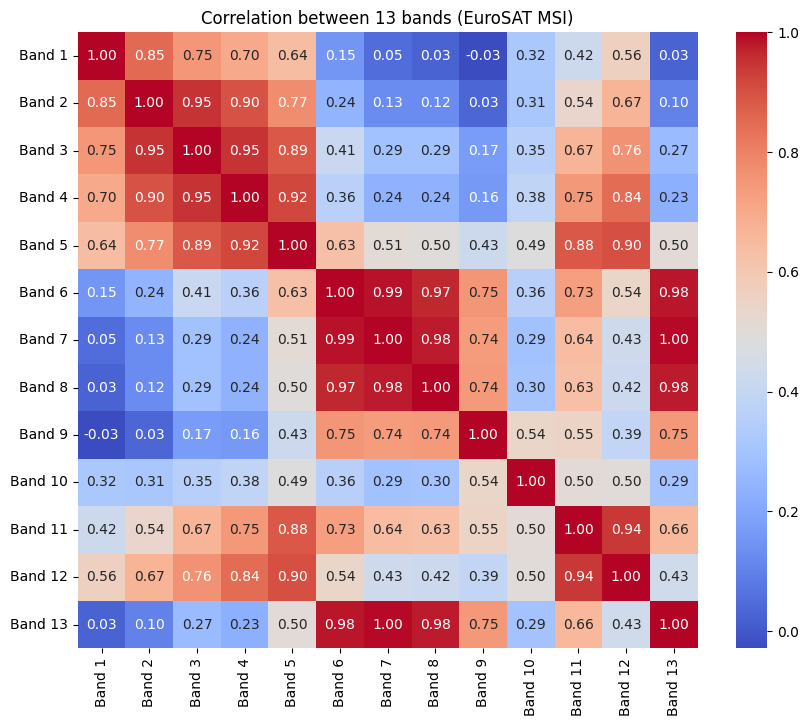

In [5]:
all_images = []
for img, _ in tfds.as_numpy(train_ds):
    all_images.append(img.astype(np.float32))

all_images = np.stack(all_images)
flattened = all_images.reshape(-1, all_images.shape[-1])

corr_matrix = np.corrcoef(flattened, rowvar=False)

plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
    xticklabels=[f"Band {i+1}" for i in range(flattened.shape[1])],
    yticklabels=[f"Band {i+1}" for i in range(flattened.shape[1])]
)
plt.title("Correlation between 13 bands (EuroSAT MSI)")
plt.show()

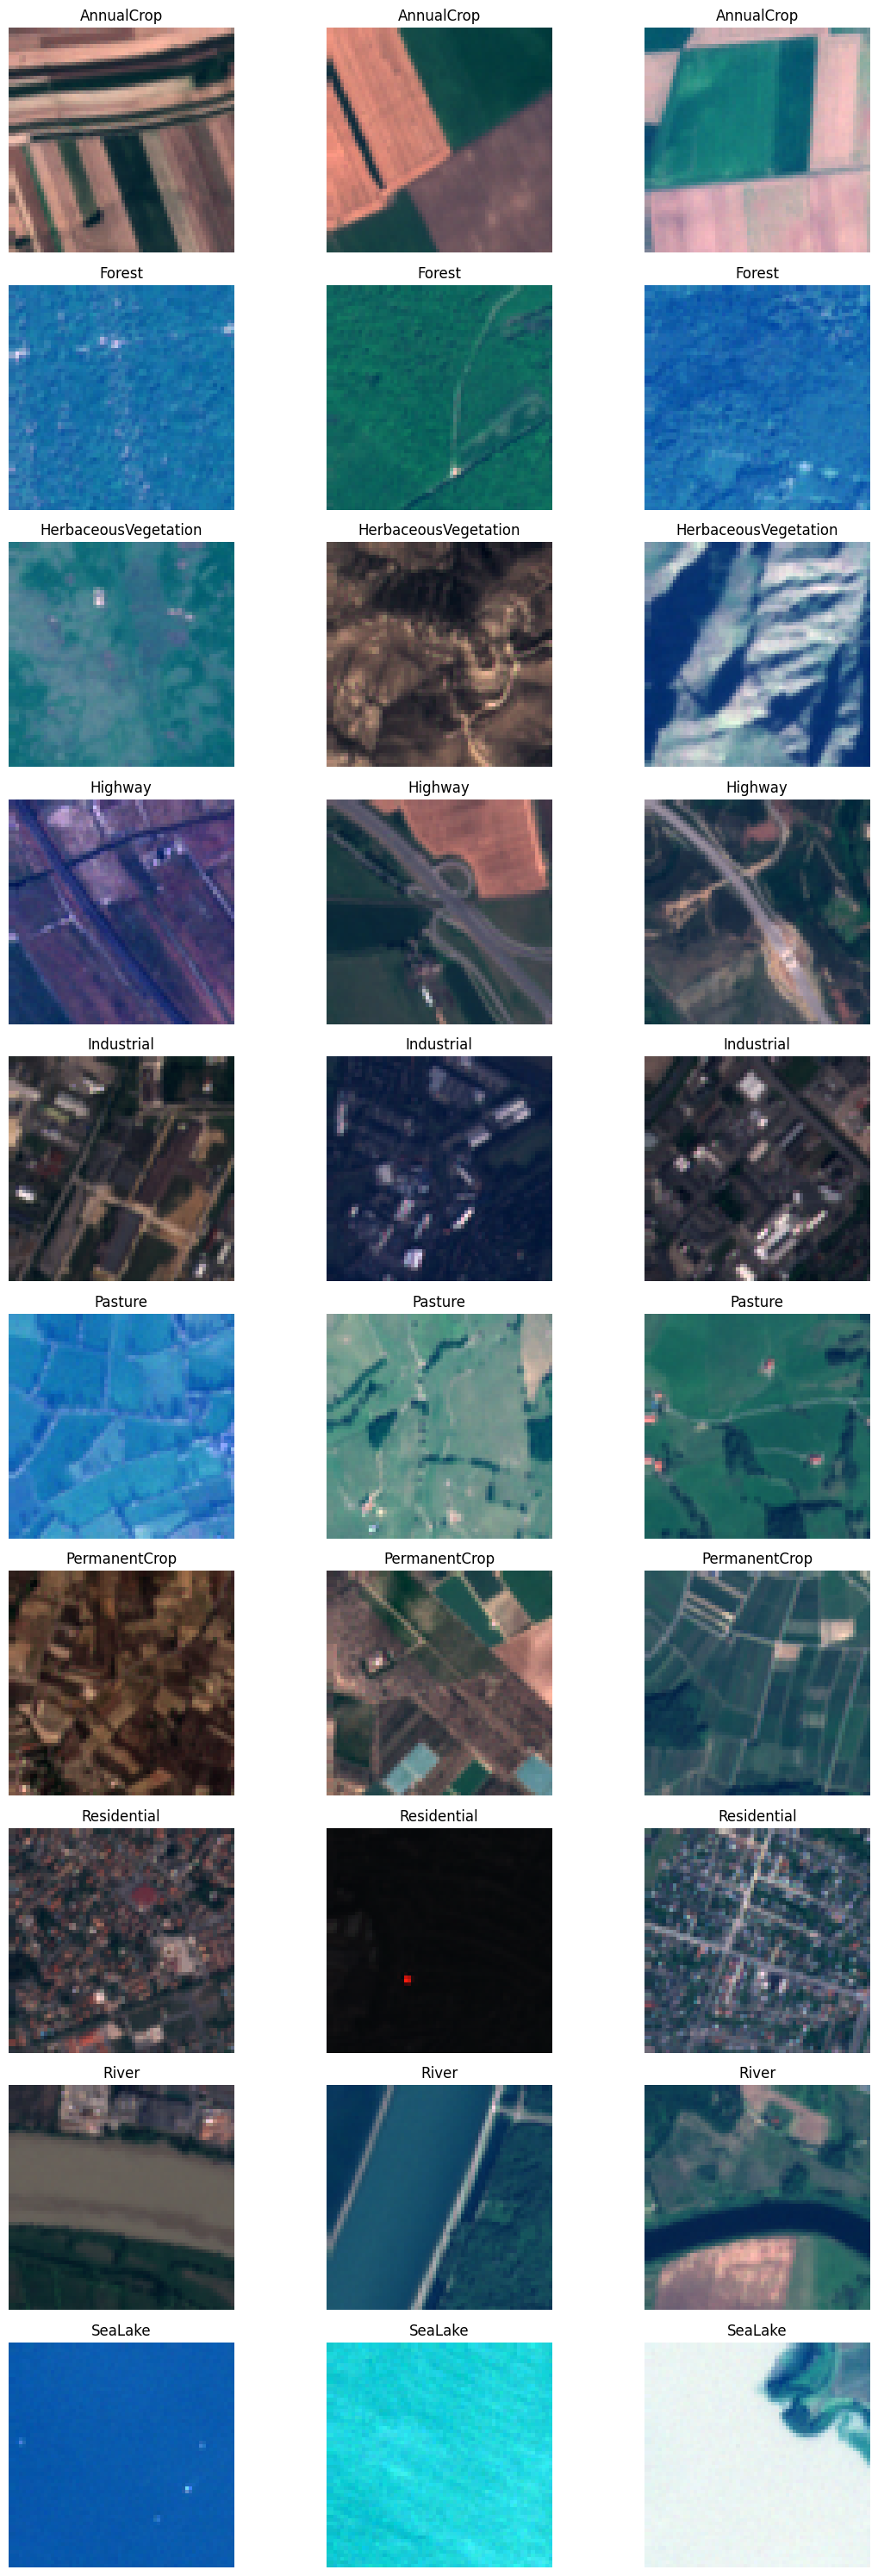

In [6]:
rgb_base_dir = "DEPI_DataSet/DEPI_DataSet_RGB"

class_names = sorted(os.listdir(rgb_base_dir))

cols = 3
rows = len(class_names)

plt.figure(figsize=(12, rows * 3))

plot_index = 1

for class_name in class_names:
    class_path = os.path.join(rgb_base_dir, class_name)
    
    images = [img for img in os.listdir(class_path) if img.endswith(".png")]
    selected_images = random.sample(images, min(cols, len(images)))

    for img_name in selected_images:
        img_path = os.path.join(class_path, img_name)
        img = plt.imread(img_path)

        plt.subplot(rows, cols, plot_index)
        plt.imshow(img)
        plt.axis("off")
        plt.title(class_name)

        plot_index += 1

plt.tight_layout()
plt.show()